In [ ]:
import os
import numpy as np
import pandas as pd
import test as test 
import matplotlib.pyplot as plt
import scipy as sc 
import pandas as pd
#
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier


In [ ]:
def fact(n):
	f = 1
	for i in range(n):
		f=f*(i+1)
	return f
	
p = int(input ('Veuillez rentrer le nombre voulu : '))
print (fact(p))

Veuillez rentrer le nombre voulu : 4
24


# Connecting to google drive (where images are stored)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = ''
cur_dir = os.getcwd()
print(cur_dir)

/content


# Data Structuring

## RRD tool installation et importation

In [ ]:
!sudo apt-get install python-rrdtool
!sudo apt-get install rrdtool python-rrdtool librrd-dev
!sudo pip install rrdtool
import rrdtool as rrd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-dejavu-core libdbi1 librrd8
The following NEW packages will be installed:
  fonts-dejavu-core libdbi1 librrd8 python-rrdtool
0 upgraded, 4 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,243 kB of archives.
After this operation, 3,628 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-dejavu-core all 2.37-1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libdbi1 amd64 0.9.0-5 [27.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 librrd8 amd64 1.7.0-1build1 [158 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-rrdtool amd64 1.7.0-1build1 [17.2 kB]
Fetched 1,243 kB in 1s (

## Creating RRD Object Class to manipulate rrd files 

In [ ]:
class RRD():
  def __init__(self,filename):
      self.filename=filename
      self.name=filename.split('/')[-1]
#------------------------------dump------------------------------
  def dump(self,filenamexml='',header='dtd',daemon=''):
    """
      [-h|--header {none,xsd,dtd}
      [-n|--no-header]
      [-d|--daemon address]
      file.rrd
      [file.xml]
    """
    if header==None:
      header='none'
    if header in ['none','dtd','xsd']:
      arg=['--header',header]
    else :
      print("wrong/Not supported xml header")
      return
    if(daemon):
      arg.append('--deamon')
      arg.append(daemon)
    if(filenamexml):
      return rrd.dump(self.filename,filenamexml,arg)
    else:
      return rrd.dump(self.filename,arg)
#------------------------------fetch--------------------------------
  def fetch(self,cf="AVERAGE",resolution='',start='',end='',align=False,daemon='',df=False):
    """
      filename
      CF
      [-r|--resolution resolution]
      [-s|--start start]
      [-e|--end end]
      [-a|--align-start]
      [-d|--daemon address]
    """
    if (cf in ["AVERAGE","MAX","MIN","LAST"]):
      arg=[]
    else : 
      print("wrong/Not supported consolidation function") 
      return
    if(resolution):
      arg.append("--resolution")
      arg.append(str(resolution))
    if(start):
      arg.append("--start")
      arg.append(str(start))
    if(end):
      arg.append("--end")
      arg.append(str(end))
    if(align):
      arg.append("-a")
    if(daemon):
      arg.append("--daemon")
      arg.append(str(daemon))
    res=rrd.fetch(self.filename,cf,arg)
    if(not(df)):
      return res
    ds=list(res[1])
    data=list(res[2])
    data=[list(k) for k in data]
    data=np.array(data)
    df=pd.DataFrame(data=data,columns=ds)
    return df
#-------------------------------------------first--------------------
  def first(self,index=0,address=""):
    """
      [--rraindex number]
      [-d|--daemon address]
    """
    if(address):
      return rrd.first(self.filename,"--rraindex",str(index),"--daemon",address)
    return rrd.first(self.filename,"--rraindex",str(index))
  def last(self,address=""):
    if(address):
      return rrd.first(self.filename,"--daemon",address)
    return rrd.first(self.filename)
#--------------------------graph--------------------------
  def DEF(self,vname,dsname,cf,step="",start="",end="",reduce="",daemon=""):
    """
    DEF:<vname>=<rrdfile>:<ds-name>:<CF>[:step=<step>][:start=<time>][:end=<time>][:reduce=<CF>][:daemon=<address>]
    """
    ch="DEF:"+vname+"="+self.filename+":"+dsname+":"+cf
    if(step):
      ch+":step="+str(step)
    if(start):
      ch+":start="+str(start)
    if(end):
      ch+":end="+str(end)
    if(reduce):
      ch+":reduce="+str(reduce)
    if(daemon):
      ch+":daemon="+str(daemon)
    return ch
  def xport(start="",end="",mawrows="",json=False,enumds="",daemon="",DEF=("","")):
    """
      [-s[--start seconds]
      [-e|--end seconds]
      [-m|--maxrows rows]
      [--step value]
      [--json]
      [--enumds]
      [--daemon address]
      [DEF:vname=rrd:ds-name:CF]
      [CDEF:vname=rpn-expression]
      [XPORT:vname[:legend]]
      """
    return (rrd.xport(DEF[0],"XPORT:"+str(DEF[1])))



    
  def ds(self,cf="AVERAGE",resolution='',start='',end='',align='',daemon=''):
    return self.fetch(cf,resolution,start,end,align,daemon,df=False)[1]
  def rows(self,cf="AVERAGE",resolution='',start='',end='',align='',daemon=''):
    return self.fetch(cf,resolution,start,end,align,daemon,df=False)[2]
  def time_range(self,cf="AVERAGE",resolution='',start='',end='',align='',daemon=''):
    return self.fetch(cf,resolution,start,end,align,daemon,df=False)[2]
  def start(self):
    return self.time_range()[0]
  def end(self):
    return self.time_range()[1]
  def step(self):
    return self.time_range[2]
  def info(self,daemon='',noflush=False,df=False):
    arg=[]
    if(daemon):
      arg.append('--daemon')
      arg.append(daemon)
    if(daemon):
      arg.append('--noflush')
    res = rrd.info(self.filename,arg)
    if(not(df)):
      return res

## Creating RRDXML Object Class to manipulate this specific  rrd files after converting them to xml format

### installation  of  lxml and importation 

In [ ]:
#import xml.etree.ElementTree as ET
import lxml.etree as le
#!sudo apt-get install python3-lxml

###RRDXML Object Class

In [ ]:
class RRDXML():
  def __init__(self,rrdObject,name):
    self.rrd=rrdObject
    self.fxml=str(name)+".xml"
    rrdObject.dump(self.fxml)
    parser = le.XMLParser(target=le.TreeBuilder())
    self.xml=le.parse("/content/"+self.fxml,parser=parser)
    self.rt=(self.xml).getroottree()
    self.dic={}
  def getEnd(self):
    lu=(self.rt).find("lastupdate")
    str(ET.tostring(lu))[14:-21]
    end=int(str(ET.tostring(lu))[14:-21])
    return end 
  def __getStep(s):
    ch=str(le.tostring(s))
    ch=ch[7:-21]
    return ch
  def __getCF(cf):
    ch=str(le.tostring(cf))
    ch=ch[6:-12]
    return ch
  def __rratonumpy(db,concateCF=True):
    ch=le.tostring(db)
    l=ch.splitlines()
    l=[str(ch).replace('--> <row>','</v>') for ch in l]
    l=[str(ch).replace('<v>','') for ch in l]
    l=[str(ch).replace("b'\\t\\t\\t <row>",'') for ch in l]
    l=[str(ch).replace("</row>",'') for ch in l]
    l=[ch.split("</v>") for ch in l]
    l=[g[:-1] for g in l]
    l.pop(0)
    l.pop()
    l.pop()
    for p in range(len(l)):
      ml=l[p]
      ch=ml[0]
      ch=ch[39:]
      ml[0]=ch
      l[p]=ml
    l=np.array(l)
    l=np.float64(l)
    return l
  def toDataFrame(self,concate=None):
    dic={}
    col=list((self.rrd).ds())
    cols=[]
    for el in (self.rt).findall('rra'):
      children = el.getchildren()
      cf,pdp,step,param,cdp,db=children[0],children[1],children[2],children[3],children[4],children[5]
      cf=RRDXML.__getCF(cf)
      step=RRDXML.__getStep(step)
      array=RRDXML.__rratonumpy(db)
      try:
        dic[step][cf]=array
      except:
        dic[step]={cf:array}
      col0=["Timestamp"]+[c+"_"+cf for c in col]
      index0=(array[:,0]).tolist()
      cols.append(col0)
      df0=pd.DataFrame(data=array,columns=col0,index=index0)
      dic[step][cf]=df0
      dic[step][cf]["step"]=step
    if(concate=="cf"):
      for step in dic.keys():
        d=pd.DataFrame()
        l=[]
        for cf in dic[step].keys():
          dic[step][cf].index=dic[step][cf].index.map(lambda x:str(int(x))+"s"+str(step))
          l.append(dic[step][cf])
        dic[step]=pd.concat(l,axis=1)
      return dic
    if(concate=="all"):
      l=[]
      cfs=dic[step].keys()
      steps=dic.keys()
      for step in dic.keys():
        d=pd.DataFrame()
        for cf in dic[step].keys():
            dic[step][cf].index=dic[step][cf].index.map(lambda x:str(int(x))+"s"+str(step))
            d=pd.concat([dic[step][cf],d],axis=1)
        l.append(d)
      dic=pd.concat(l)
      dic.drop_duplicates(inplace=True)
      #delete duplicated  columns
      dic = dic.loc[:,~dic.columns.duplicated()]
      #dic.index = dic.index.map(int)
      dic.Timestamp=dic.Timestamp.map(int)
      dic.step=dic.step.map(int)
      return dic
    return dic


    


#### Testing 

##### Functions 

In [ ]:
def getStep(s):
  ch=str(le.tostring(s))
  ch=ch[7:-21]
  return ch

In [ ]:
def getCF(cf):
  ch=str(le.tostring(cf))
  ch=ch[6:-12]
  return ch


In [ ]:
def rratonumpy(db):
  ch=le.tostring(db)
  l=ch.splitlines()
  l=[str(ch).replace('--> <row>','</v>') for ch in l]
  l=[str(ch).replace('<v>','') for ch in l]
  l=[str(ch).replace("b'\\t\\t\\t <row>",'') for ch in l]
  l=[str(ch).replace("</row>",'') for ch in l]
  #l=[str(ch).replace("\\t\\t\\t<!-- 2021-11-17 14:14:00 CET / ",'') for ch in l]
  l=[ch.split("</v>") for ch in l]
  l=[g[:-1] for g in l]
  l.pop(0)
  l.pop()
  l.pop()
  for p in range(len(l)):
    ml=l[p]
    ch=ml[0]
    ch=ch[39:]
    ml[0]=ch
    l[p]=ml
  l=np.array(l)
  l=np.float64(l)
  return l

In [ ]:
def getEnd(end):
  lu=rt.find("lastupdate")
  str(ET.tostring(lu))[14:-21]
  end=int(str(ET.tostring(lu))[14:-21])
  return end

In [ ]:
dic={}
for el in rt.findall('rra'):
  e=(el.getchildren())
  cf,step,db=e[0],e[1],e[-1]
  cf=getCF(cf)
  step=getStep(step)
  if(step=='1'):
    dic[cf]=rratonumpy(db)
dic.keys()

NameError: ignored

##### Tests

In [ ]:
lxml.etree.XMLParser

In [ ]:
help(lxml.etree.ElementTree)

In [ ]:
parser = le.XMLParser(target=le.TreeBuilder())
f=le.parse("/content/gdrive/MyDrive/PRIM/315.xml",parser=parser)

In [ ]:
ter=f.iter()

In [ ]:
for ob in ter:
  print(ob)


In [ ]:
rt=f.getroottree()

In [ ]:
rra=rt.findall("rra")

In [ ]:
rra0=rra[0]

In [ ]:
children = rra0.getchildren()
cf,pdp,step,param,cdp,db=children[0],children[1],children[2],children[3],children[4],children[5]

In [ ]:
children

In [ ]:
ch=le.tostring(db)

In [ ]:
rratonumpy(db)

In [ ]:
le.tostring(db)

In [ ]:
xml316_vmfarm3=RRDXML(rrd316['vmfarm3.weytop.com'],316)

In [ ]:
xml316_vmfarm3_dict=xml316_vmfarm3.toDataFrame(concate='all')

In [ ]:
xml316_vmfarm3_dict.keys()

In [ ]:
for el in xml316_vmfarm3_dict.values():
  print(el.shape)

In [ ]:
xml316_vmfarm3_dict.describe()

In [ ]:
l[1]

In [ ]:
a=xml316_vmfarm3_dict

In [ ]:
a

In [ ]:
b.loc[]

In [ ]:
rrdfile=RRD("/content/gdrive/MyDrive/PRIM/Data/vmfarm3.weytop.com/db/pve2-node/airtop-vm-farm3")
rrdXmlfile=RRDXML(rrdfile,"file")
rrdXmlfile.toDataFrame(concate='all')

## Creating VM Object Class to manipulate VMs

### VM Object Class

In [ ]:
class VM():
  def __path():
    return "/content/gdrive/MyDrive/PRIM/Data/"
  def __vm():
    return "db/pve2-vm/"
  def __Nodes():
    return os.listdir(VM.__path())
  def __init__(self,id):
    self.id= id
    self.RRDs={}
    for node in VM.__Nodes():
      pathn=VM.__path()+node+"/"+VM.__vm()
      if (str(id) in os.listdir(pathn)):
        (self.RRDs)[node]=(RRD(pathn+"/"+str(id)))
  def __str__(self):
    return str({"id":self.id,"RRDs":self.RRDs})
  def toDataFrame(self,concate=''):
    l=[]
    for node in self.RRDs:
      xml=RRDXML(self.RRDs[node],str(self.id)+"_"+node)
      df= xml.toDataFrame(concate='all')
      df['Node']=node
      l.append(df)
    return pd.concat(l)


###Testing 

In [ ]:
path="/content/gdrive/MyDrive/PRIM/Data/"
vm="db/pve2-vm/"
Nodes=os.listdir(path)

In [ ]:
Nodes

In [ ]:
pathn=path+Nodes[0]+"/"+vm

In [ ]:
pathn

In [ ]:
str(307) in os.listdir(pathn)

In [ ]:
vm316=VM(316)
vm316.toDataFrame()

In [ ]:
df316.des

In [ ]:
AllVMsDF.Node=encode(AllVMsDF,"Node")

In [ ]:
AllVMsDF

In [ ]:
rrd316_0=vm316.RRDs
rrd

## Creating Node Object Class to manipulate  Nodes

### Node Object Class

In [ ]:
class Node():
  def __path():
    return "/content/gdrive/MyDrive/PRIM/Data/"
  def __getAllsubfiles(path):
    L=[]
    for path, subdirs, files in os.walk(path):
      for name in files:
        L.append(os.path.join(path, name))
    return L
  def __toDF(listOfRRDs,colname="--"):
    l=[]
    for RRDObject in listOfRRDs :
      xml=RRDXML(RRDObject,RRDObject.name)
      df= xml.toDataFrame(concate='all')
      df.index=df.index.map(lambda string:string+colname[0:2]+RRDObject.name)
      df[colname]=RRDObject.name
      l.append(df)
    return pd.concat(l)
  def __Names(listOfRRDs):
    return [RRDObject.name for RRDObject in listOfRRDs]
    """
    """
  def __init__(self,id):
    self.folder=Node.__path()+str(id)
    self.id=str(id)
    self.journals=os.listdir(self.folder+'/journal')
    self.storages=Node.__getAllsubfiles(self.folder+'/db/pve2-storage')
    self.storages=[RRD(k) for k in self.storages]
    self.resources=Node.__getAllsubfiles(self.folder+'/db/pve2-node')
    self.resources=[RRD(k) for k in self.resources]
    self.vms=Node.__getAllsubfiles(self.folder+'/db/pve2-vm')
    self.vms=[RRD(k) for k in self.vms]
  def Resources(self):
    return Node.__toDF(self.resources,"Resfname")
  def Storages(self):
    return Node.__toDF(self.storages,"Support")
  def VMs(self):
    df =Node.__toDF(self.vms,"VM")
    df.VM=df.VM.map(int)
    return df
  def Resources__Names(self):
    return Node.__Names(self.resources)
  def Storages__Names(self):
    return Node.__Names(self.storages)
  def VMs__Names(self):
    return Node.__Names(self.vms)
  def Journals__Names(self):
    return self.journals
  def start(self,step=60):
    dfr,dfs,dfv=self.Resources(),self.Storages(),self.VMs()
    dfr,dfs,dfv=dfr[dfr.step==step],dfs[dfs.step==step],dfv[dfv.step==step]
    tr,ts,tv=dfr.Timestamp.min(),dfs.Timestamp.min(),dfv.Timestamp.min()
    return int(min(tr,ts,tv))
  def end(self,step=60):
    dfr,dfs,dfv=self.Resources(),self.Storages(),self.VMs()
    dfr,dfs,dfv=dfr[dfr.step==step],dfs[dfs.step==step],dfv[dfv.step==step]
    tr,ts,tv=dfr.Timestamp.max(),dfs.Timestamp.max(),dfv.Timestamp.max()
    return int(max(tr,ts,tv))




### Testing 

##### Tests

In [ ]:
def getAllsubfiles(path):
  L=[]
  for path, subdirs, files in os.walk(path):
    for name in files:
        L.append(os.path.join(path, name))
  return L
  

In [ ]:
# List of Nodes
Nodes=os.listdir(data_path)
Nodes

['vpn1.airtop.io', 'vmfarm3.weytop.com']

In [ ]:
# List of All VMs
VMs=[]
for node in Nodes :
  VMs+=os.listdir(data_path+node+"/"+vm_path)
VMs=set(VMs)

VMs=list(VMs)
VMs.sort()
VMs=VMs[1:]
print(VMs)
print("Numbver of VMs :",len(VMs))

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '187', '188', '189', '190', '191', '192', '193', '194', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '261', '262', '263', '264', '267', '268', '269', '270', '271'

In [ ]:
# instanciation of a VM Object for each VM
VMObjects=[VM(vm) for vm in VMs]

In [ ]:
dfs=[vm.toDataFrame() for vm in VMObjects]

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
dfsAll=[]
for m in range(len(dfs)):
  df=dfs[m]
  df["VM"]=int(VMs[m])
  df.index=df.index.map(lambda x:x+"vm"+VMs[m])
  dfsAll.append(df)
AllVMsDF=pd.concat(dfsAll)


In [ ]:
# instansiation a Node Object for each Node 
NodeObjects=[Node(node) for node in Nodes]

In [ ]:
df=(NodeObjects[0]).VMs()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
df60=df[df.step==60]
t0=int(df60.min().Timestamp)
df60.Timestamp=df60.Timestamp.map(lambda t:t0+((t-t0)//60)*60)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df60.sort_values(by=["Timestamp"],inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df60GbTimestamp=df60.groupby("Timestamp")

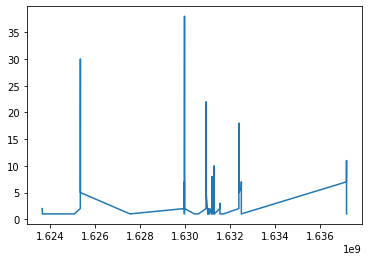

In [ ]:
x=df60GbTimestamp.first().index
y=df60GbTimestamp.size().values
plt.plot(x,y)

In [ ]:
df60gb

,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM
Timestamp,,,,,,,,,,,,,,,,,,,,,,
1623655920,8.0,0.056804,1.717987e+10,6.179995e+09,1.073742e+11,0.0,5324.800000,15.966667,0.000000,21947.733334,120,8.0,0.056804,1.717987e+10,6.179995e+09,1.073742e+11,0.0,5324.800000,15.966667,0.000000,21947.733334,215
1623655980,8.0,0.055409,1.717987e+10,6.180091e+09,1.073742e+11,0.0,4327.448148,2.966667,0.000000,21811.200000,120,8.0,0.055409,1.717987e+10,6.180091e+09,1.073742e+11,0.0,4327.448148,2.966667,0.000000,21811.200000,215
1623656040,8.0,0.056838,1.717987e+10,6.180056e+09,1.073742e+11,0.0,4911.351852,19.783333,0.000000,22186.666666,120,8.0,0.056838,1.717987e+10,6.180056e+09,1.073742e+11,0.0,4911.351852,19.783333,0.000000,22186.666666,215
1623656100,8.0,0.056386,1.717987e+10,6.180337e+09,1.073742e+11,0.0,4794.700000,3.350000,0.000000,21196.800000,120,8.0,0.056386,1.717987e+10,6.180337e+09,1.073742e+11,0.0,4794.700000,3.350000,0.000000,21196.800000,215
1623656160,8.0,0.056614,1.717987e+10,6.180381e+09,1.073742e+11,0.0,6649.766667,6.883333,0.000000,21742.933334,120,8.0,0.056614,1.717987e+10,6.180381e+09,1.073742e+11,0.0,6649.766667,6.883333,0.000000,21742.933334,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158620,30.0,1.688671,4.724464e+10,3.545479e+10,3.779571e+11,0.0,137.243333,33.130000,25.600000,56109.226667,660,30.0,1.688671,4.724464e+10,3.545479e+10,3.779571e+11,0.0,137.243333,33.130000,25.600000,56109.226667,2888
1637158680,30.0,1.648929,4.724464e+10,3.545489e+10,3.779571e+11,0.0,67.245000,21.518333,1109.333333,34093.226666,660,30.0,1.648929,4.724464e+10,3.545489e+10,3.779571e+11,0.0,67.245000,21.518333,1109.333333,34093.226666,2888
1637158740,12.0,0.555690,1.717987e+10,1.035478e+10,1.374390e+11,0.0,52.441667,12.758333,0.000000,1703.253333,240,12.0,0.555690,1.717987e+10,1.035478e+10,1.374390e+11,0.0,52.441667,12.758333,0.000000,1703.253333,791


In [ ]:
df60

,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM
1623655920s60VM111,1623655920,4.0,0.028128,8.589935e+09,3.282193e+09,1.073742e+11,0.0,2663.650000,9.083333,0.0,11741.866667,60,4.0,0.028128,8.589935e+09,3.282193e+09,1.073742e+11,0.0,2663.650000,9.083333,0.0,11741.866667,111
1623655920s60VM104,1623655920,4.0,0.028675,8.589935e+09,2.897802e+09,0.000000e+00,0.0,2661.150000,6.883333,0.0,10205.866667,60,4.0,0.028675,8.589935e+09,2.897802e+09,0.000000e+00,0.0,2661.150000,6.883333,0.0,10205.866667,104
1623655980s60VM111,1623655980,4.0,0.027368,8.589935e+09,3.281678e+09,1.073742e+11,0.0,2164.974074,2.583333,0.0,10987.140741,60,4.0,0.027368,8.589935e+09,3.281678e+09,1.073742e+11,0.0,2164.974074,2.583333,0.0,10987.140741,111
1623655980s60VM104,1623655980,4.0,0.028040,8.589935e+09,2.898413e+09,0.000000e+00,0.0,2162.474074,0.383333,0.0,10824.059259,60,4.0,0.028040,8.589935e+09,2.898413e+09,0.000000e+00,0.0,2162.474074,0.383333,0.0,10824.059259,104
1623656040s60VM111,1623656040,4.0,0.028094,8.589935e+09,3.282000e+09,1.073742e+11,0.0,2459.025926,13.283333,0.0,11131.259259,60,4.0,0.028094,8.589935e+09,3.282000e+09,1.073742e+11,0.0,2459.025926,13.283333,0.0,11131.259259,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158740s60VM304,1637158740,2.0,0.014691,4.294967e+09,3.469690e+09,3.435974e+10,0.0,25.315000,6.683333,0.0,1703.253333,60,2.0,0.014691,4.294967e+09,3.469690e+09,3.435974e+10,0.0,25.315000,6.683333,0.0,1703.253333,304
1637158740s60VM101,1637158740,2.0,0.513462,4.294967e+09,3.557219e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,60,2.0,0.513462,4.294967e+09,3.557219e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,101
1637158740s60VM100,1637158740,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,60,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,100
1637158800s60VM101,1637158800,2.0,0.513370,4.294967e+09,3.557211e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,60,2.0,0.513370,4.294967e+09,3.557211e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,101


In [ ]:
df60gb

,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM
Timestamp,,,,,,,,,,,,,,,,,,,,,,
1623655920,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1623655980,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1623656040,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1623656100,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1623656160,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158620,11,10,11,10,11,11,10,10,10,10,11,11,10,11,10,11,11,10,10,10,10,11
1637158680,11,10,11,10,11,11,10,10,10,10,11,11,10,11,10,11,11,10,10,10,10,11
1637158740,4,3,4,3,4,4,3,3,3,3,4,4,3,4,3,4,4,3,3,3,3,4


In [ ]:
df60gb[df60gb==0]

,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM
Timestamp,,,,,,,,,,,,,,,,,,,,,,
1623655920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623655980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623656040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623656100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623656160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1637158680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1637158740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df60gb

,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM
Timestamp,,,,,,,,,,,,,,,,,,,,,,
1623655920,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1623655980,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1623656040,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1623656100,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1623656160,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158620,11,10,11,10,11,11,10,10,10,10,11,11,10,11,10,11,11,10,10,10,10,11
1637158680,11,10,11,10,11,11,10,10,10,10,11,11,10,11,10,11,11,10,10,10,10,11
1637158740,4,3,4,3,4,4,3,3,3,3,4,4,3,4,3,4,4,3,3,3,3,4


In [ ]:
node0=Node('vmfarm3.weytop.com')

In [ ]:
node0.Resources().head(1)

,Timestamp,loadavg_MAX,maxcpu_MAX,cpu_MAX,iowait_MAX,memtotal_MAX,memused_MAX,swaptotal_MAX,swapused_MAX,roottotal_MAX,rootused_MAX,netin_MAX,netout_MAX,step,loadavg_AVERAGE,maxcpu_AVERAGE,cpu_AVERAGE,iowait_AVERAGE,memtotal_AVERAGE,memused_AVERAGE,swaptotal_AVERAGE,swapused_AVERAGE,roottotal_AVERAGE,rootused_AVERAGE,netin_AVERAGE,netout_AVERAGE,Resfname
1637154960s60Reairtop-vm-farm3,1637154960,5.830333,32.0,0.185966,0.000005,2.700643e+11,6.912730e+10,4.999606e+09,38797312.0,7.804286e+11,7.361477e+11,79343.661667,5170.018333,60,5.830333,32.0,0.185966,0.000005,2.700643e+11,6.912730e+10,4.999606e+09,38797312.0,7.804286e+11,7.361477e+11,79343.661667,5170.018333,airtop-vm-farm3


In [ ]:
node0.Storages().head(1)

,Timestamp,total_MAX,used_MAX,step,total_AVERAGE,used_AVERAGE,Support
1637154780s60Sulocal,1637154780,7.804286e+11,7.361476e+11,60,7.804286e+11,7.361476e+11,local


In [ ]:
node0.VMs().head(1)

,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM
1632266160s60VM300,1632266160,2.0,NaN,4.294967e+09,NaN,2.684355e+11,0.0,NaN,NaN,NaN,NaN,60,2.0,NaN,4.294967e+09,NaN,2.684355e+11,0.0,NaN,NaN,NaN,NaN,300


In [ ]:
rrdn=RRD("/content/gdrive/MyDrive/PRIM/Data/vmfarm3.weytop.com/db/pve2-node/airtop-vm-farm3")

In [ ]:
rrdn.fetch()

((1638888060, 1638974520, 60),
 ('loadavg',
  'maxcpu',
  'cpu',
  'iowait',
  'memtotal',
  'memused',
  'swaptotal',
  'swapused',
  'roottotal',
  'rootused',
  'netin',
  'netout'),
 [(None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, None, None, None, None),
  (None, None, None, None, None, None, None, None, Non

In [ ]:
rrdnode=RRD("/content/gdrive/MyDrive/PRIM/Data/vmfarm3.weytop.com/db/pve2-node/airtop-vm-farm3")
xmlnode=RRDXML(rrdnode,'node')

In [ ]:
xmlnode.toDataFrame(concate='all')

,Timestamp,loadavg_MAX,maxcpu_MAX,cpu_MAX,iowait_MAX,memtotal_MAX,memused_MAX,swaptotal_MAX,swapused_MAX,roottotal_MAX,rootused_MAX,netin_MAX,netout_MAX,step,Timestamp,loadavg_AVERAGE,maxcpu_AVERAGE,cpu_AVERAGE,iowait_AVERAGE,memtotal_AVERAGE,memused_AVERAGE,swaptotal_AVERAGE,swapused_AVERAGE,roottotal_AVERAGE,rootused_AVERAGE,netin_AVERAGE,netout_AVERAGE,step
1.637155e+09,1.637155e+09,5.830333,32.0,0.185966,0.000005,2.700643e+11,6.912730e+10,4.999606e+09,38797312.0,7.804286e+11,7.361477e+11,7.934366e+04,5.170018e+03,60,1.637155e+09,5.830333,32.0,0.185966,0.000005,2.700643e+11,6.912730e+10,4.999606e+09,38797312.0,7.804286e+11,7.361477e+11,79343.661667,5170.018333,60
1.637155e+09,1.637155e+09,5.832500,32.0,0.186355,0.000000,2.700643e+11,6.912544e+10,4.999606e+09,38797312.0,7.804286e+11,7.361477e+11,7.852518e+04,5.108123e+03,60,1.637155e+09,5.832500,32.0,0.186355,0.000000,2.700643e+11,6.912544e+10,4.999606e+09,38797312.0,7.804286e+11,7.361477e+11,78525.176667,5108.123333,60
1.637155e+09,1.637155e+09,5.675833,32.0,0.188997,0.000000,2.700643e+11,6.912621e+10,4.999606e+09,38797312.0,7.804286e+11,7.361480e+11,8.293060e+04,7.904420e+03,60,1.637155e+09,5.675833,32.0,0.188997,0.000000,2.700643e+11,6.912621e+10,4.999606e+09,38797312.0,7.804286e+11,7.361480e+11,82930.603333,7904.420000,60
1.637155e+09,1.637155e+09,5.854167,32.0,0.219738,0.000006,2.700643e+11,6.912537e+10,4.999606e+09,38797312.0,7.804286e+11,7.361488e+11,7.763093e+04,1.438878e+04,60,1.637155e+09,5.854167,32.0,0.219738,0.000006,2.700643e+11,6.912537e+10,4.999606e+09,38797312.0,7.804286e+11,7.361488e+11,77630.935000,14388.778333,60
1.637155e+09,1.637155e+09,6.609667,32.0,0.217228,0.000006,2.700643e+11,6.912603e+10,4.999606e+09,38797312.0,7.804286e+11,7.361508e+11,8.688435e+04,1.285778e+04,60,1.637155e+09,6.609667,32.0,0.217228,0.000006,2.700643e+11,6.912603e+10,4.999606e+09,38797312.0,7.804286e+11,7.361508e+11,86884.348333,12857.785000,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.634170e+09,1.634170e+09,13.580000,32.0,0.413215,0.002177,2.700643e+11,1.080200e+11,4.999606e+09,38797312.0,7.804286e+11,4.802300e+11,1.270744e+07,3.356026e+05,604800,1.634170e+09,2.878324,32.0,0.089276,0.000008,2.700643e+11,1.044735e+11,4.999606e+09,38797312.0,7.804286e+11,4.444015e+11,32828.980921,10459.959873,604800
1.634774e+09,1.634774e+09,17.328667,32.0,0.533089,0.002861,2.700643e+11,1.183041e+11,4.999606e+09,38797312.0,7.804286e+11,5.226273e+11,9.887185e+06,1.101310e+07,604800,1.634774e+09,11.116794,32.0,0.343830,0.000005,2.700643e+11,9.378079e+10,4.999606e+09,38797312.0,7.804286e+11,4.971460e+11,23616.898536,28814.904706,604800
1.635379e+09,1.635379e+09,6.038333,32.0,0.189264,0.003097,2.700643e+11,3.586860e+10,4.999606e+09,38797312.0,7.804286e+11,5.486867e+11,5.774873e+06,1.303946e+07,604800,1.635379e+09,3.109766,32.0,0.096666,0.000003,2.700643e+11,2.884992e+10,4.999606e+09,38797312.0,7.804286e+11,5.297938e+11,9952.242895,10430.458268,604800
1.635984e+09,1.635984e+09,6.176667,32.0,0.195271,0.002407,2.700643e+11,4.060693e+10,4.999606e+09,38797312.0,7.804286e+11,6.035206e+11,6.602506e+06,1.037555e+06,604800,1.635984e+09,3.275173,32.0,0.101880,0.000002,2.700643e+11,3.614885e+10,4.999606e+09,38797312.0,7.804286e+11,5.562167e+11,6750.226795,3235.522112,604800


In [ ]:
xmlnode.toDataFrame(concate='all').describe()

,Timestamp,loadavg_MAX,maxcpu_MAX,cpu_MAX,iowait_MAX,memtotal_MAX,memused_MAX,swaptotal_MAX,swapused_MAX,roottotal_MAX,rootused_MAX,netin_MAX,netout_MAX,Timestamp,loadavg_AVERAGE,maxcpu_AVERAGE,cpu_AVERAGE,iowait_AVERAGE,memtotal_AVERAGE,memused_AVERAGE,swaptotal_AVERAGE,swapused_AVERAGE,roottotal_AVERAGE,rootused_AVERAGE,netin_AVERAGE,netout_AVERAGE
count,3.500000e+02,328.000000,328.0,328.000000,328.000000,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.500000e+02,328.000000,328.0,328.000000,328.000000,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02,3.280000e+02
mean,1.632483e+09,6.102576,32.0,0.190852,0.000912,2.700643e+11,5.917314e+10,4.999606e+09,6.085975e+07,7.804286e+11,6.616449e+11,3.045715e+06,2.299290e+06,1.632483e+09,4.672867,32.0,0.145987,0.000008,2.700643e+11,5.800165e+10,4.999606e+09,4.159411e+07,7.804286e+11,6.557959e+11,9.118824e+04,2.298290e+04
std,1.004125e+07,2.620252,0.0,0.080475,0.004190,0.000000e+00,1.875126e+10,0.000000e+00,2.792490e+08,0.000000e+00,1.027747e+11,8.755219e+06,1.344905e+07,1.004125e+07,2.672403,0.0,0.083391,0.000037,0.000000e+00,1.886410e+10,0.000000e+00,2.869413e+07,0.000000e+00,1.094647e+11,1.117092e+05,1.368343e+05
min,1.594858e+09,0.256000,32.0,0.002058,0.000000,2.700643e+11,5.114644e+09,4.999606e+09,0.000000e+00,7.804286e+11,1.828596e+10,2.461983e+03,1.814758e+03,1.594858e+09,0.018087,32.0,0.000446,0.000000,2.700643e+11,4.809500e+09,4.999606e+09,0.000000e+00,7.804286e+11,1.821818e+10,5.598827e+01,3.383574e+01
25%,1.635044e+09,5.089375,32.0,0.154514,0.000006,2.700643e+11,5.013479e+10,4.999606e+09,3.879731e+07,7.804286e+11,6.392618e+11,1.294913e+05,1.296056e+04,1.635044e+09,3.239774,32.0,0.100878,0.000001,2.700643e+11,5.006607e+10,4.999606e+09,3.879731e+07,7.804286e+11,6.380593e+11,6.439436e+03,3.647966e+03
50%,1.636853e+09,5.909167,32.0,0.186858,0.000021,2.700643e+11,5.982233e+10,4.999606e+09,3.879731e+07,7.804286e+11,6.727604e+11,2.151394e+05,1.740228e+04,1.636853e+09,5.057439,32.0,0.157455,0.000002,2.700643e+11,5.981242e+10,4.999606e+09,3.879731e+07,7.804286e+11,6.726826e+11,7.362615e+04,5.671618e+03
75%,1.637132e+09,6.613083,32.0,0.209216,0.000102,2.700643e+11,6.912397e+10,4.999606e+09,3.879731e+07,7.804286e+11,7.361477e+11,2.139896e+06,5.198429e+04,1.637132e+09,6.192113,32.0,0.192876,0.000003,2.700643e+11,6.912250e+10,4.999606e+09,3.879731e+07,7.804286e+11,7.360179e+11,1.466463e+05,8.827226e+03
max,1.637159e+09,17.328667,32.0,0.533089,0.041257,2.700643e+11,1.183041e+11,4.999606e+09,4.999606e+09,7.804286e+11,7.804118e+11,8.246529e+07,1.221345e+08,1.637159e+09,15.128090,32.0,0.467694,0.000492,2.700643e+11,1.133852e+11,4.999606e+09,3.646434e+08,7.804286e+11,7.780348e+11,1.093617e+06,2.222484e+06


## Creating Platform Object Class to manipulate  Nodes,VM,Storage

### Platform Object class

In [ ]:
class Platform :
  path="/content/gdrive/MyDrive/PRIM/Data/"
  vm="db/pve2-vm/"
  def __Nodes(path=path):
    return os.listdir(path)
  def __concat(listOfRRDs,colname):
    listOfDF=[RRDObject.name for RRDObject in listOfRRDs]
  def __init__(self,name,path=path,description=""):
    self.path=path
    self.nodes=[Node(n) for n in Platform.__Nodes(path=path)]
    self.name=name
    self.description=description
    self.update()
  def update(self):
    self.dfResources = self.Resources()
    self.dfVMs = self.VMs()
    self.dfStorages = self.Storages()
  def start(self,step=60):
    t=[node.start(step=step) for node in self.nodes]
    return int(min(t))
  def end(self,step=60):
    t=[node.end(step=step) for node in self.nodes]
    return int(max(t))
  def VMs__Names(self):
    VMs=[]
    for node in Platform.__Nodes() :
        VMs+=os.listdir(self.path+node+"/"+"db/pve2-vm/")
    VMs=set(VMs)
    VMs=list(VMs)
    VMs.sort()
    VMs=VMs[1:]
    return VMs
  def VMs(self):
    L=[]
    for node in self.nodes:
      df=node.VMs()
      df["Node"]=node.id
      L.append(df)
    return pd.concat(L)
  def Resources(self):
    L=[]
    for node in self.nodes:
      df=node.Resources()
      df["Node"]=node.id
      L.append(df)
    return pd.concat(L)
  def Storages(self):
    L=[]
    for node in self.nodes:
      df=node.Storages()
      df["Node"]=node.id
      L.append(df)
    return pd.concat(L)
  def Nodes__Names(self):
    return Platform.__Nodes(self.path)
  def Journals_Names(self):
    L=[]
    for node in self.nodes:
      L=L+node.Journals_Names()
    return list(set(L))
  def __str__(self):
    ch=""
    i=0
    for node in self.nodes:
      ch+="\n---------------------------------------------\n"
      ch+="Node"+str(i)+": "+node.id+"\n"
      ch+="VMs :"+str(sorted(node.VMs__Names()))+"\n"
      ch+="Storage Supports: "+str(node.Storages__Names())+"\n"
      ch+="Resources: "+str(node.Resources__Names())+"\n"
      ch+="Journals: "+str(node.Journals__Names())+"\n"
      i+=1
    if(self.description):
      ch+="\n---------------------------------------------\n"
      ch+="Description: "+str(self.description)+"\n"
    return ch




    

###Testing

In [ ]:
path

''

In [ ]:
platform=Platform("Weytop")

In [ ]:
print(platform)


---------------------------------------------
Node0: vpn1.airtop.io
VMs :['306', '157', '156', '302', '230', '262', '107', '184', '211', '205', '307', '151', '251', '215', '209', '178', '148', '162', '245', '219', '208', '176', '304', '179', '240', '177', '200', '144', '319', '101', '212', '228', '234', '231', '225', '264', '174', '257', '187', '198', '100', '182', '189', '181', '300', '273', '153', '305', '226', '191', '147', '293', '296', '217', '246', '222', '271', '233', '131', '248', '170', '220', '218', '236', '197', '139', '150', '258', '104', '297', '188', '145', '242', '159', '194', '321', '214', '276', '155', '320', '256', '227', '173', '275', '136', '210', '308', '229', '252', '202', '295', '238', '216', '243', '232', '281', '255', '318', '183', '111', '316', '135', '193', '203', '224', '201', '294', '254', '160', '196', '250', '249', '286', '277', '137', '253', '235', '278', '102', '298', '299', '142', '141', '269', '138', '244', '301', '223', '322', '204', '163', '169', '

In [ ]:
platform.VMs()

,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM,Node
1632488160s60VM306,1632488160,2.0,0.016393,4.294967e+09,3.603895e+09,3.435974e+10,0.0,6.450833e+01,8.933333,0.000000e+00,1.290069e+04,60,2.0,0.016393,4.294967e+09,3.603895e+09,3.435974e+10,0.0,64.508333,8.933333,0.000000,12900.693333,306,vpn1.airtop.io
1632488220s60VM306,1632488220,2.0,0.016686,4.294967e+09,3.603879e+09,3.435974e+10,0.0,1.934583e+02,40.366667,0.000000e+00,1.021952e+04,60,2.0,0.016686,4.294967e+09,3.603879e+09,3.435974e+10,0.0,193.458333,40.366667,0.000000,10219.520000,306,vpn1.airtop.io
1632488280s60VM306,1632488280,2.0,0.015712,4.294967e+09,3.603904e+09,3.435974e+10,0.0,8.230833e+01,8.933333,0.000000e+00,6.183253e+03,60,2.0,0.015712,4.294967e+09,3.603904e+09,3.435974e+10,0.0,82.308333,8.933333,0.000000,6183.253333,306,vpn1.airtop.io
1632488340s60VM306,1632488340,2.0,0.014902,4.294967e+09,3.603904e+09,3.435974e+10,0.0,1.174583e+02,12.916667,0.000000e+00,5.683200e+03,60,2.0,0.014902,4.294967e+09,3.603904e+09,3.435974e+10,0.0,117.458333,12.916667,0.000000,5683.200000,306,vpn1.airtop.io
1632488400s60VM306,1632488400,2.0,0.019102,4.294967e+09,3.603904e+09,3.435974e+10,0.0,1.022917e+02,12.916667,0.000000e+00,3.100160e+03,60,2.0,0.019102,4.294967e+09,3.603904e+09,3.435974e+10,0.0,102.291667,12.916667,0.000000,3100.160000,306,vpn1.airtop.io
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634169600s604800VM315,1634169600,2.0,1.031020,4.294967e+09,3.580067e+09,3.435974e+10,0.0,1.055546e+07,96454.266667,3.019887e+07,3.007901e+07,604800,2.0,0.035493,4.294967e+09,3.575919e+09,3.435974e+10,0.0,10510.402501,748.062560,69911.268571,148506.631450,315,vmfarm3.weytop.com
1634774400s604800VM315,1634774400,2.0,0.778702,4.294967e+09,3.568613e+09,3.435974e+10,0.0,7.781170e+05,11678.361667,1.894373e+07,1.207829e+07,604800,2.0,0.385590,4.294967e+09,3.558878e+09,3.435974e+10,0.0,2888.431752,99.393679,22183.486156,30738.761534,315,vmfarm3.weytop.com
1635379200s604800VM315,1635379200,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,604800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
1635984000s604800VM315,1635984000,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,604800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com


# Functions

In [ ]:
def encode(df,col,binary=False):
  l=sorted(df[col].unique().tolist())
  index=list(range(len(l)))
  if(binary):
    index=[2**i for i in index]
  print(l,index)
  if(not(binary)):
    return df[col].map(lambda x:(l.index(x)))
  else :
    return df[col].map(lambda x:(2**(l.index(x))))
    

In [ ]:
def bin_to_list(binary):
  return [int(d) for d in str(binary)[2:]]

In [ ]:
# this function check if two columns (_MAX / _AVERAGE) have the same information with a rate > thresh 
def check(df,cols,thresh=0.5):
  L=[]
  for col in cols:
    dfcp=(df[col+'_MAX']==df[col+'_AVERAGE'])
    if dfcp.sum()/dfcp.shape[0]>=thresh:
      L.append(col)
  return L
# this function delete one of the repeated columns and keep only one column
def delete(df,cols):
  df_copy=df.copy()
  #columnsMax=[col+"_MAX" for col in cols]
  columnsAverage=[col+"_AVERAGE" for col in cols]
  for col in cols:
    df_copy.rename(columns={col+"_MAX":col},inplace=True)
  df_copy.drop(columns=columnsAverage,inplace=True)
  return df_copy


In [ ]:
def hammingDistance(n1, n2=0) :
 
    x = n1 ^ n2
    setBits = 0
 
    while (x > 0) :
        setBits += x & 1
        x >>= 1
     
    return setBits

In [ ]:
# Useful for converting time ⌚ 
second=1
minut=60*second
hour=60*minut
day=24*hour
week=7*day
month=30*day
year=12*month

from datetime import datetime
def fromtimestamp(Timestamp):
  return (datetime.fromtimestamp(Timestamp))


In [ ]:
def isweekend(date):
  return int(fromtimestamp(int(date)).weekday()>4)
def day(date):
  return int(fromtimestamp(int(date)).date().day)
def weekday(date):
  return fromtimestamp(int(date)).weekday()
def hour(date):
  return fromtimestamp(int(date)).timetuple()[1]

In [ ]:
ts=1637107900

d=fromtimestamp(ts)
day(ts)

17

# Data Importation and Visualisation 

In [ ]:
import rrdtool as rrd
weytop=Platform("weytop",description="Platform")

In [ ]:
start,end,step=weytop.start(),weytop.end(),60

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
start,end,step

(1616929620, 1637159100, 60)

In [ ]:
fromtimestamp(start),fromtimestamp(end),step

(datetime.datetime(2021, 3, 28, 11, 7),
 datetime.datetime(2021, 11, 17, 14, 25),
 60)

In [ ]:
print(weytop)


---------------------------------------------
Node0: vpn1.airtop.io
VMs :['100', '101', '102', '104', '107', '111', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '187', '188', '189', '190', '191', '192', '193', '194', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '261', '262', '263', '264', '267', '268', '

In [ ]:
dfResources=weytop.dfResources.copy()
dfStorages=weytop.dfStorages.copy()
dfVMs=weytop.dfVMs.copy()

#### verifier somme = resources

In [ ]:
dfVMs.Timestamp=dfVMs.Timestamp.map(lambda t:int(t/60)*60) # il faut expliquer !!

In [ ]:
dfVMs

,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM,Node
1632488160s60VM306,1632488160,2.0,0.016393,4.294967e+09,3.603895e+09,3.435974e+10,0.0,6.450833e+01,8.933333,0.000000e+00,1.290069e+04,60,2.0,0.016393,4.294967e+09,3.603895e+09,3.435974e+10,0.0,64.508333,8.933333,0.000000,12900.693333,306,vpn1.airtop.io
1632488220s60VM306,1632488220,2.0,0.016686,4.294967e+09,3.603879e+09,3.435974e+10,0.0,1.934583e+02,40.366667,0.000000e+00,1.021952e+04,60,2.0,0.016686,4.294967e+09,3.603879e+09,3.435974e+10,0.0,193.458333,40.366667,0.000000,10219.520000,306,vpn1.airtop.io
1632488280s60VM306,1632488280,2.0,0.015712,4.294967e+09,3.603904e+09,3.435974e+10,0.0,8.230833e+01,8.933333,0.000000e+00,6.183253e+03,60,2.0,0.015712,4.294967e+09,3.603904e+09,3.435974e+10,0.0,82.308333,8.933333,0.000000,6183.253333,306,vpn1.airtop.io
1632488340s60VM306,1632488340,2.0,0.014902,4.294967e+09,3.603904e+09,3.435974e+10,0.0,1.174583e+02,12.916667,0.000000e+00,5.683200e+03,60,2.0,0.014902,4.294967e+09,3.603904e+09,3.435974e+10,0.0,117.458333,12.916667,0.000000,5683.200000,306,vpn1.airtop.io
1632488400s60VM306,1632488400,2.0,0.019102,4.294967e+09,3.603904e+09,3.435974e+10,0.0,1.022917e+02,12.916667,0.000000e+00,3.100160e+03,60,2.0,0.019102,4.294967e+09,3.603904e+09,3.435974e+10,0.0,102.291667,12.916667,0.000000,3100.160000,306,vpn1.airtop.io
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634169600s604800VM315,1634169600,2.0,1.031020,4.294967e+09,3.580067e+09,3.435974e+10,0.0,1.055546e+07,96454.266667,3.019887e+07,3.007901e+07,604800,2.0,0.035493,4.294967e+09,3.575919e+09,3.435974e+10,0.0,10510.402501,748.062560,69911.268571,148506.631450,315,vmfarm3.weytop.com
1634774400s604800VM315,1634774400,2.0,0.778702,4.294967e+09,3.568613e+09,3.435974e+10,0.0,7.781170e+05,11678.361667,1.894373e+07,1.207829e+07,604800,2.0,0.385590,4.294967e+09,3.558878e+09,3.435974e+10,0.0,2888.431752,99.393679,22183.486156,30738.761534,315,vmfarm3.weytop.com
1635379200s604800VM315,1635379200,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,604800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
1635984000s604800VM315,1635984000,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,604800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com


In [ ]:
dfResources.keys()

Index(['Timestamp', 'loadavg_MAX', 'maxcpu_MAX', 'cpu_MAX', 'iowait_MAX',
       'memtotal_MAX', 'memused_MAX', 'swaptotal_MAX', 'swapused_MAX',
       'roottotal_MAX', 'rootused_MAX', 'netin_MAX', 'netout_MAX', 'step',
       'loadavg_AVERAGE', 'maxcpu_AVERAGE', 'cpu_AVERAGE', 'iowait_AVERAGE',
       'memtotal_AVERAGE', 'memused_AVERAGE', 'swaptotal_AVERAGE',
       'swapused_AVERAGE', 'roottotal_AVERAGE', 'rootused_AVERAGE',
       'netin_AVERAGE', 'netout_AVERAGE', 'Resfname', 'Node'],
      dtype='object')

In [ ]:
dfVMs.describe()

,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM
count,7.980000e+04,48496.000000,13458.000000,4.849600e+04,1.345800e+04,4.849600e+04,48496.0,1.345500e+04,1.345500e+04,1.345500e+04,1.345500e+04,79800.000000,48496.000000,13458.000000,4.849600e+04,1.345800e+04,4.849600e+04,48496.0,1.345500e+04,13455.000000,1.345500e+04,1.345500e+04,79800.000000
mean,1.626516e+09,4.677363,0.208553,8.972938e+09,3.633543e+09,4.893103e+10,0.0,2.208477e+05,1.377404e+04,4.713848e+06,7.659403e+06,132132.000000,4.673278,0.104974,8.960292e+09,3.552266e+09,4.891845e+10,0.0,6.799321e+03,257.417629,1.247058e+05,2.265301e+06,229.956140
std,1.080883e+07,2.572057,0.248726,6.170756e+09,1.155677e+09,5.752928e+10,0.0,1.217391e+06,2.419470e+05,3.702412e+07,6.394980e+07,236845.245359,2.569826,0.182495,6.163598e+09,8.385496e+08,5.752042e+10,0.0,5.456765e+04,995.472295,1.196760e+06,1.218585e+07,72.280414
min,1.575504e+09,1.000000,0.000000,5.368709e+08,4.124660e+07,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,60.000000,1.000000,0.000000,5.368709e+08,4.124660e+07,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,100.000000
25%,1.625098e+09,2.000000,0.024995,4.294967e+09,3.487154e+09,3.435974e+10,0.0,8.210417e+01,2.745000e+00,0.000000e+00,4.559787e+03,1800.000000,2.000000,0.014594,4.294967e+09,3.470085e+09,3.435974e+10,0.0,2.963167e+01,0.501481,0.000000e+00,3.067733e+03,172.750000
50%,1.629965e+09,4.000000,0.065769,4.294967e+09,3.578181e+09,3.435974e+10,0.0,2.874490e+03,9.641667e+01,8.448000e+02,4.704939e+04,10800.000000,4.000000,0.025315,4.294967e+09,3.576167e+09,3.435974e+10,0.0,1.651656e+03,19.434444,4.375704e+01,1.363392e+04,229.500000
75%,1.632218e+09,8.000000,0.404066,1.717987e+10,3.632946e+09,3.435974e+10,0.0,1.434339e+04,2.564502e+03,6.721655e+05,1.026014e+06,43200.000000,8.000000,0.038794,1.717987e+10,3.630879e+09,3.435974e+10,0.0,2.667832e+03,194.700573,1.048853e+04,4.835856e+04,300.000000
max,1.637159e+09,8.000000,1.443590,3.435974e+10,2.084753e+10,3.221225e+11,0.0,4.765336e+07,1.635004e+07,1.491018e+09,2.847561e+09,604800.000000,8.000000,0.950223,3.435974e+10,1.787053e+10,3.221225e+11,0.0,1.991841e+06,52199.951315,6.221386e+07,7.522386e+07,346.000000


#### different columns with the same information 

In [ ]:
cols=['loadavg', 'maxcpu', 'cpu', 'iowait','memtotal', 'memused', 'swaptotal', 'swapused','roottotal', 'rootused', 'netin', 'netout']
columns_to_keep_only_one=check(dfResources,cols,thresh=0.8)
columns_to_keep_only_one

['maxcpu', 'memtotal', 'swaptotal', 'roottotal']

In [ ]:
delete(dfResources,columns_to_keep_only_one)

,Timestamp,loadavg_MAX,maxcpu,cpu_MAX,iowait_MAX,memtotal,memused_MAX,swaptotal,swapused_MAX,roottotal,rootused_MAX,netin_MAX,netout_MAX,step,loadavg_AVERAGE,cpu_AVERAGE,iowait_AVERAGE,memused_AVERAGE,swapused_AVERAGE,rootused_AVERAGE,netin_AVERAGE,netout_AVERAGE,Resfname,Node
1637154720s60Revpn1,1637154720,3.771167,40.0,0.091340,0.000008,6.744238e+10,5.178850e+10,1.023406e+09,629309440.0,1.965883e+12,8.305297e+11,4.560687e+03,4.850000e+00,60,3.771167,0.091340,0.000008,5.178850e+10,629309440.0,8.305297e+11,4560.686667,4.850000,vpn1,vpn1.airtop.io
1637154780s60Revpn1,1637154780,3.516000,40.0,0.091296,0.000006,6.744238e+10,5.178660e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5.071528e+03,5.298167e+01,60,3.516000,0.091296,0.000006,5.178660e+10,629309440.0,8.305298e+11,5071.528333,52.981667,vpn1,vpn1.airtop.io
1637154840s60Revpn1,1637154840,3.629167,40.0,0.099240,0.000009,6.744238e+10,5.178489e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4.774568e+03,3.339833e+01,60,3.629167,0.099240,0.000009,5.178489e+10,629309440.0,8.305298e+11,4774.568333,33.398333,vpn1,vpn1.airtop.io
1637154900s60Revpn1,1637154900,4.108667,40.0,0.111171,0.000012,6.744238e+10,5.178410e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5.283807e+03,1.240000e+01,60,4.108667,0.111171,0.000012,5.178410e+10,629309440.0,8.305298e+11,5283.806667,12.400000,vpn1,vpn1.airtop.io
1637154960s60Revpn1,1637154960,4.355833,40.0,0.109304,0.000018,6.744238e+10,5.178449e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4.624240e+03,5.320000e+00,60,4.355833,0.109304,0.000018,5.178449e+10,629309440.0,8.305298e+11,4624.240000,5.320000,vpn1,vpn1.airtop.io
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634169600s604800Reairtop-vm-farm3,1634169600,13.580000,32.0,0.413215,0.002177,2.700643e+11,1.080200e+11,4.999606e+09,38797312.0,7.804286e+11,4.802300e+11,1.270744e+07,3.356026e+05,604800,2.878324,0.089276,0.000008,1.044735e+11,38797312.0,4.444015e+11,32828.980921,10459.959873,airtop-vm-farm3,vmfarm3.weytop.com
1634774400s604800Reairtop-vm-farm3,1634774400,17.328667,32.0,0.533089,0.002861,2.700643e+11,1.183041e+11,4.999606e+09,38797312.0,7.804286e+11,5.226273e+11,9.887185e+06,1.101310e+07,604800,11.116794,0.343830,0.000005,9.378079e+10,38797312.0,4.971460e+11,23616.898536,28814.904706,airtop-vm-farm3,vmfarm3.weytop.com
1635379200s604800Reairtop-vm-farm3,1635379200,6.038333,32.0,0.189264,0.003097,2.700643e+11,3.586860e+10,4.999606e+09,38797312.0,7.804286e+11,5.486867e+11,5.774873e+06,1.303946e+07,604800,3.109766,0.096666,0.000003,2.884992e+10,38797312.0,5.297938e+11,9952.242895,10430.458268,airtop-vm-farm3,vmfarm3.weytop.com
1635984000s604800Reairtop-vm-farm3,1635984000,6.176667,32.0,0.195271,0.002407,2.700643e+11,4.060693e+10,4.999606e+09,38797312.0,7.804286e+11,6.035206e+11,6.602506e+06,1.037555e+06,604800,3.275173,0.101880,0.000002,3.614885e+10,38797312.0,5.562167e+11,6750.226795,3235.522112,airtop-vm-farm3,vmfarm3.weytop.com


### Main

In [ ]:
### Code

In [ ]:
dfVMs_60=dfVMs[dfVMs.step==60]
dfResources_60=dfResources[dfResources.step==60]

In [ ]:
dfVMs_60.Node=encode(dfVMs_60,'Node',binary=False)
dfResources_60.Node=encode(dfResources_60,'Node',binary=False)

['vmfarm3.weytop.com', 'vpn1.airtop.io'] [0, 1]
['vmfarm3.weytop.com', 'vpn1.airtop.io'] [0, 1]


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
def synchro(t,step=60):
  return int(round((t/step)*step))

In [ ]:
#Synchronisation 
dfVMs_60.Timestamp=dfVMs_60.Timestamp.map(synchro)
dfResources_60.Timestamp=dfResources_60.Timestamp.map(synchro)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
dfVMs_60_sum=dfVMs_60.groupby(by=["Timestamp","Node"]).sum()
dfVMs_60_sum.VM = dfVMs_60_sum.VM.map(hammingDistance)
dfVMs_60_sum

,,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM
Timestamp,Node,,,,,,,,,,,,,,,,,,,,,,
1617313200,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,60,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,4
1617313260,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,60,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,4
1617313320,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,60,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,4
1617313380,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,60,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,4
1617313440,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,60,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158860,1,2.0,0.513050,4.294967e+09,3.557217e+09,3.435974e+10,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,60,2.0,0.513050,4.294967e+09,3.557217e+09,3.435974e+10,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,4
1637158920,0,86.0,3.040602,1.803886e+11,4.290017e+10,1.340030e+12,0.0,211090.333333,5652.033333,1.019708e+06,1.418590e+08,2340,86.0,3.040602,1.803886e+11,4.290017e+10,1.340030e+12,0.0,211090.333333,5652.033333,1.019708e+06,1.418590e+08,10
1637158980,0,86.0,3.419798,1.803886e+11,4.290019e+10,1.340030e+12,0.0,209048.500000,5131.250000,3.023264e+07,1.541234e+08,2340,86.0,3.419798,1.803886e+11,4.290019e+10,1.340030e+12,0.0,209048.500000,5131.250000,3.023264e+07,1.541234e+08,10


In [ ]:
dfResources_60

,Timestamp,loadavg_MAX,maxcpu_MAX,cpu_MAX,iowait_MAX,memtotal_MAX,memused_MAX,swaptotal_MAX,swapused_MAX,roottotal_MAX,rootused_MAX,netin_MAX,netout_MAX,step,loadavg_AVERAGE,maxcpu_AVERAGE,cpu_AVERAGE,iowait_AVERAGE,memtotal_AVERAGE,memused_AVERAGE,swaptotal_AVERAGE,swapused_AVERAGE,roottotal_AVERAGE,rootused_AVERAGE,netin_AVERAGE,netout_AVERAGE,Resfname,Node
1637154720s60Revpn1,1637154720,3.771167,40.0,0.091340,0.000008,6.744238e+10,5.178850e+10,1.023406e+09,629309440.0,1.965883e+12,8.305297e+11,4560.686667,4.850000,60,3.771167,40.0,0.091340,0.000008,6.744238e+10,5.178850e+10,1.023406e+09,629309440.0,1.965883e+12,8.305297e+11,4560.686667,4.850000,vpn1,1
1637154780s60Revpn1,1637154780,3.516000,40.0,0.091296,0.000006,6.744238e+10,5.178660e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5071.528333,52.981667,60,3.516000,40.0,0.091296,0.000006,6.744238e+10,5.178660e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5071.528333,52.981667,vpn1,1
1637154840s60Revpn1,1637154840,3.629167,40.0,0.099240,0.000009,6.744238e+10,5.178489e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4774.568333,33.398333,60,3.629167,40.0,0.099240,0.000009,6.744238e+10,5.178489e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4774.568333,33.398333,vpn1,1
1637154900s60Revpn1,1637154900,4.108667,40.0,0.111171,0.000012,6.744238e+10,5.178410e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5283.806667,12.400000,60,4.108667,40.0,0.111171,0.000012,6.744238e+10,5.178410e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5283.806667,12.400000,vpn1,1
1637154960s60Revpn1,1637154960,4.355833,40.0,0.109304,0.000018,6.744238e+10,5.178449e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4624.240000,5.320000,60,4.355833,40.0,0.109304,0.000018,6.744238e+10,5.178449e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4624.240000,5.320000,vpn1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158860s60Reairtop-vm-farm3,1637158860,6.328333,32.0,0.191746,0.000005,2.700643e+11,6.912537e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,212407.816670,8001.283333,60,6.328333,32.0,0.191746,0.000005,2.700643e+11,6.912537e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,212407.816670,8001.283333,airtop-vm-farm3,0
1637158920s60Reairtop-vm-farm3,1637158920,6.275000,32.0,0.189343,0.000000,2.700643e+11,6.912391e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,210969.850000,5778.350000,60,6.275000,32.0,0.189343,0.000000,2.700643e+11,6.912391e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,210969.850000,5778.350000,airtop-vm-farm3,0
1637158980s60Reairtop-vm-farm3,1637158980,6.258333,32.0,0.214389,0.000000,2.700643e+11,6.912504e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,208867.650000,5248.733333,60,6.258333,32.0,0.214389,0.000000,2.700643e+11,6.912504e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,208867.650000,5248.733333,airtop-vm-farm3,0
1637159040s60Reairtop-vm-farm3,1637159040,6.231667,32.0,0.189732,0.000006,2.700643e+11,6.912552e+10,4.999606e+09,38797312.0,7.804286e+11,7.362012e+11,211468.250000,6057.766667,60,6.231667,32.0,0.189732,0.000006,2.700643e+11,6.912552e+10,4.999606e+09,38797312.0,7.804286e+11,7.362012e+11,211468.250000,6057.766667,airtop-vm-farm3,0


In [ ]:
dfVMs_60_sum.keys()

Index(['maxcpu_MAX', 'cpu_MAX', 'maxmem_MAX', 'mem_MAX', 'maxdisk_MAX',
       'disk_MAX', 'netin_MAX', 'netout_MAX', 'diskread_MAX', 'diskwrite_MAX',
       'step', 'maxcpu_AVERAGE', 'cpu_AVERAGE', 'maxmem_AVERAGE',
       'mem_AVERAGE', 'maxdisk_AVERAGE', 'disk_AVERAGE', 'netin_AVERAGE',
       'netout_AVERAGE', 'diskread_AVERAGE', 'diskwrite_AVERAGE', 'VM'],
      dtype='object')

In [ ]:
dfResources_60_count=dfResources_60.groupby(by=['Timestamp']).count()
dfResources_60_count[dfResources_60_count.Node==2]

,loadavg_MAX,maxcpu_MAX,cpu_MAX,iowait_MAX,memtotal_MAX,memused_MAX,swaptotal_MAX,swapused_MAX,roottotal_MAX,rootused_MAX,netin_MAX,netout_MAX,step,loadavg_AVERAGE,maxcpu_AVERAGE,cpu_AVERAGE,iowait_AVERAGE,memtotal_AVERAGE,memused_AVERAGE,swaptotal_AVERAGE,swapused_AVERAGE,roottotal_AVERAGE,rootused_AVERAGE,netin_AVERAGE,netout_AVERAGE,Resfname,Node
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,
1637154960,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1637155020,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1637155080,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1637155140,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1637155200,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158620,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1637158680,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1637158740,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [ ]:
dfResources_60

,Timestamp,loadavg_MAX,maxcpu_MAX,cpu_MAX,iowait_MAX,memtotal_MAX,memused_MAX,swaptotal_MAX,swapused_MAX,roottotal_MAX,rootused_MAX,netin_MAX,netout_MAX,step,loadavg_AVERAGE,maxcpu_AVERAGE,cpu_AVERAGE,iowait_AVERAGE,memtotal_AVERAGE,memused_AVERAGE,swaptotal_AVERAGE,swapused_AVERAGE,roottotal_AVERAGE,rootused_AVERAGE,netin_AVERAGE,netout_AVERAGE,Resfname,Node
1637154720s60Revpn1,1637154720,3.771167,40.0,0.091340,0.000008,6.744238e+10,5.178850e+10,1.023406e+09,629309440.0,1.965883e+12,8.305297e+11,4560.686667,4.850000,60,3.771167,40.0,0.091340,0.000008,6.744238e+10,5.178850e+10,1.023406e+09,629309440.0,1.965883e+12,8.305297e+11,4560.686667,4.850000,vpn1,1
1637154780s60Revpn1,1637154780,3.516000,40.0,0.091296,0.000006,6.744238e+10,5.178660e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5071.528333,52.981667,60,3.516000,40.0,0.091296,0.000006,6.744238e+10,5.178660e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5071.528333,52.981667,vpn1,1
1637154840s60Revpn1,1637154840,3.629167,40.0,0.099240,0.000009,6.744238e+10,5.178489e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4774.568333,33.398333,60,3.629167,40.0,0.099240,0.000009,6.744238e+10,5.178489e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4774.568333,33.398333,vpn1,1
1637154900s60Revpn1,1637154900,4.108667,40.0,0.111171,0.000012,6.744238e+10,5.178410e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5283.806667,12.400000,60,4.108667,40.0,0.111171,0.000012,6.744238e+10,5.178410e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5283.806667,12.400000,vpn1,1
1637154960s60Revpn1,1637154960,4.355833,40.0,0.109304,0.000018,6.744238e+10,5.178449e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4624.240000,5.320000,60,4.355833,40.0,0.109304,0.000018,6.744238e+10,5.178449e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4624.240000,5.320000,vpn1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158860s60Reairtop-vm-farm3,1637158860,6.328333,32.0,0.191746,0.000005,2.700643e+11,6.912537e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,212407.816670,8001.283333,60,6.328333,32.0,0.191746,0.000005,2.700643e+11,6.912537e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,212407.816670,8001.283333,airtop-vm-farm3,0
1637158920s60Reairtop-vm-farm3,1637158920,6.275000,32.0,0.189343,0.000000,2.700643e+11,6.912391e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,210969.850000,5778.350000,60,6.275000,32.0,0.189343,0.000000,2.700643e+11,6.912391e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,210969.850000,5778.350000,airtop-vm-farm3,0
1637158980s60Reairtop-vm-farm3,1637158980,6.258333,32.0,0.214389,0.000000,2.700643e+11,6.912504e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,208867.650000,5248.733333,60,6.258333,32.0,0.214389,0.000000,2.700643e+11,6.912504e+10,4.999606e+09,38797312.0,7.804286e+11,7.362001e+11,208867.650000,5248.733333,airtop-vm-farm3,0
1637159040s60Reairtop-vm-farm3,1637159040,6.231667,32.0,0.189732,0.000006,2.700643e+11,6.912552e+10,4.999606e+09,38797312.0,7.804286e+11,7.362012e+11,211468.250000,6057.766667,60,6.231667,32.0,0.189732,0.000006,2.700643e+11,6.912552e+10,4.999606e+09,38797312.0,7.804286e+11,7.362012e+11,211468.250000,6057.766667,airtop-vm-farm3,0


In [ ]:
dfResouces_60_gb=dfResources_60.groupby(["Timestamp"])

In [ ]:
dfResources.head(1)

,Timestamp,loadavg_MAX,maxcpu_MAX,cpu_MAX,iowait_MAX,memtotal_MAX,memused_MAX,swaptotal_MAX,swapused_MAX,roottotal_MAX,rootused_MAX,netin_MAX,netout_MAX,step,loadavg_AVERAGE,maxcpu_AVERAGE,cpu_AVERAGE,iowait_AVERAGE,memtotal_AVERAGE,memused_AVERAGE,swaptotal_AVERAGE,swapused_AVERAGE,roottotal_AVERAGE,rootused_AVERAGE,netin_AVERAGE,netout_AVERAGE,Resfname,Node
1637154720s60Revpn1,1637154720,3.771167,40.0,0.09134,0.000008,6.744238e+10,5.178850e+10,1.023406e+09,629309440.0,1.965883e+12,8.305297e+11,4560.686667,4.85,60,3.771167,40.0,0.09134,0.000008,6.744238e+10,5.178850e+10,1.023406e+09,629309440.0,1.965883e+12,8.305297e+11,4560.686667,4.85,vpn1,vpn1.airtop.io


In [ ]:
dfResouces_60_gb

In [ ]:
dfResources_60.Node.unique().tolist()

[1, 0]

In [ ]:
from numpy.testing._private.utils import raises
def evaluate_at(sub_df,features,ponderations,MinMaxs,n_Nodes,VM=None,binaryEncode=False):
  if len(features)!=len(ponderations) or len(features)!=len(MinMaxs):
    print ("lenght of features, ponderations and MinMaxs should the same !!!")
    raise
  if not(all(feature in sub_df.columns for feature in features)):
    print("unkown features !!!"+str(sub_df.keys()))
    raise
  
  if binaryEncode:
    All_nodes=[2**i for i in range(n_Nodes)]
  else :
    All_nodes=[i for i in range(n_Nodes)]

  ON_nodes=sub_df.Node.unique().tolist()
  OFF_nodes=[n for n in All_nodes if n not in ON_nodes]
  out_df=sub_df.copy()
  out_df.index=out_df.Node
  for n in OFF_nodes:
    out_df.loc[n]=0
  out_df.Node=out_df.index

  n_features = len(features) 
  
  for i in range(n_features) :
    m,M = MinMaxs[i]
    feature = features[i]
    out_df[feature+"_mean"]= out_df[feature].mean()
    out_df[feature+"_std"]= out_df[feature].std()
    out_df[feature+"_std%"]=out_df[feature+"_std"]/(M-m)
    nodes=reversed(out_df.sort_values(by=feature).Node.tolist())
    nodes=[str(node) for node in nodes]
    out_df[feature+'_Decision'] = '=>'.join(nodes)
  
  out_df["Global_std%"]=0
  for i in range(n_features) :
    feature = features[i]
    coef = ponderations[i]
    out_df["Global_std%"]=out_df["Global_std%"]+coef*out_df[feature+"_std%"]
  if (VM==None):
    C=[]
    for node in All_nodes:
      s=0
      for i in range(n_features):
        m,M = MinMaxs[i]
        feature = features[i]
        coef = ponderations[i]
        s+=coef*out_df[feature].loc[node]/(M-m)
      C.append(s)
    C=np.array(C)
    nodes = np.argsort(C)[::-1]
    nodes=[str(node) for node in nodes]
    out_df['Global_Decision'] = '=>'.join(nodes)
    cols =[feature+"_mean" for feature in features ]+[feature+"_std" for feature in features ]+[feature+"_std%" for feature in features ]+[feature+"_Decision" for feature in features ]
    cols=cols+["Global_std%",'Global_Decision']
    out = out_df[cols][out_df.Node==0].loc[0]
  else :
    out=0
      
  return out
    

In [ ]:
features =['loadavg_MAX','cpu_MAX','iowait_MAX','memused_MAX','swapused_MAX']
ponderations=list(range(len(features)))
mins,maxs=dfResources[features].min().tolist(),dfResources[features].max().tolist()
MinMaxs=[]
for i in range(len(mins)):
  m=mins[i]
  M=maxs[i]
  MinMaxs.append((m,M))

In [ ]:
str(dfResources.keys())

"Index(['Timestamp', 'loadavg_MAX', 'maxcpu_MAX', 'cpu_MAX', 'iowait_MAX',\n       'memtotal_MAX', 'memused_MAX', 'swaptotal_MAX', 'swapused_MAX',\n       'roottotal_MAX', 'rootused_MAX', 'netin_MAX', 'netout_MAX', 'step',\n       'loadavg_AVERAGE', 'maxcpu_AVERAGE', 'cpu_AVERAGE', 'iowait_AVERAGE',\n       'memtotal_AVERAGE', 'memused_AVERAGE', 'swaptotal_AVERAGE',\n       'swapused_AVERAGE', 'roottotal_AVERAGE', 'rootused_AVERAGE',\n       'netin_AVERAGE', 'netout_AVERAGE', 'Resfname', 'Node'],\n      dtype='object')"

In [ ]:
df=dfResouces_60_gb.apply(lambda x:evaluate_at(x,features,ponderations,MinMaxs,2,binaryEncode=False))

In [ ]:
df

,loadavg_MAX_mean,cpu_MAX_mean,iowait_MAX_mean,memused_MAX_mean,swapused_MAX_mean,loadavg_MAX_std,cpu_MAX_std,iowait_MAX_std,memused_MAX_std,swapused_MAX_std,loadavg_MAX_std%,cpu_MAX_std%,iowait_MAX_std%,memused_MAX_std%,swapused_MAX_std%,loadavg_MAX_Decision,cpu_MAX_Decision,iowait_MAX_Decision,memused_MAX_Decision,swapused_MAX_Decision,Global_std%,Global_Decision
Timestamp,,,,,,,,,,,,,,,,,,,,,,
1616929620,0.000000,0.000419,0.000012,1.760709e+09,222167040.0,0.000000,0.000592,0.000017,2.490019e+09,3.141916e+08,0.000000,0.001041,0.000042,0.021364,0.062843,0=>1,1=>0,1=>0,1=>0,1=>0,0.316590,1=>0
1616929680,0.000000,0.000419,0.000011,1.760779e+09,222167040.0,0.000000,0.000592,0.000016,2.490118e+09,3.141916e+08,0.000000,0.001041,0.000040,0.021364,0.062843,0=>1,1=>0,1=>0,1=>0,1=>0,0.316587,1=>0
1616929740,0.000000,0.000414,0.000010,1.760247e+09,222167040.0,0.000000,0.000585,0.000015,2.489365e+09,3.141916e+08,0.000000,0.001028,0.000037,0.021358,0.062843,0=>1,1=>0,1=>0,1=>0,1=>0,0.316550,1=>0
1616929800,0.000000,0.000421,0.000012,1.760443e+09,222167040.0,0.000000,0.000595,0.000017,2.489643e+09,3.141916e+08,0.000000,0.001045,0.000042,0.021360,0.062843,0=>1,1=>0,1=>0,1=>0,1=>0,0.316584,1=>0
1616929860,0.000000,0.000413,0.000012,1.760619e+09,222167040.0,0.000000,0.000585,0.000018,2.489892e+09,3.141916e+08,0.000000,0.001027,0.000044,0.021363,0.062843,0=>1,1=>0,1=>0,1=>0,1=>0,0.316577,1=>0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158860,5.431000,0.153421,0.000105,6.046520e+10,334053376.0,1.269021,0.054199,0.000142,1.224734e+10,4.175551e+08,0.032909,0.095265,0.000358,0.105078,0.083518,0=>1,0=>1,1=>0,0=>1,1=>0,0.745288,0=>1
1637158920,3.137500,0.094671,0.000000,3.456195e+10,19398656.0,4.437095,0.133886,0.000000,4.887799e+10,2.743384e+07,0.115065,0.235329,0.000000,0.419358,0.005487,0=>1,0=>1,1=>0,0=>1,0=>1,1.515353,0=>1
1637158980,3.129167,0.107194,0.000000,3.456252e+10,19398656.0,4.425310,0.151596,0.000000,4.887879e+10,2.743384e+07,0.114759,0.266458,0.000000,0.419365,0.005487,0=>1,0=>1,1=>0,0=>1,0=>1,1.546503,0=>1


In [ ]:
print("Evaluation parameters \n","features :",features,"\n","Ponderations :",ponderations,"\n","MinMaxs :",MinMaxs,"\n","Number of nodes :",2,"\n","Vm : None")
df

Evaluation parameters 
 features : ['loadavg_MAX', 'cpu_MAX', 'iowait_MAX', 'memused_MAX', 'swapused_MAX'] 
 Ponderations : [0, 1, 2, 3, 4] 
 MinMaxs : [(0.0, 38.561666667), (0.00081160567712, 0.56974154462), (0.0, 0.3952733491), (1749899468.8, 118304079190.0), (0.0, 4999606272.0)] 
 Number of nodes : 2 
 Vm : None


""


In [ ]:
df.index = df.index.map(lambda x:x[0])
df

,MEM_mean,CPU_mean,netin_mean,netout_mean,MEM_std,CPU_std,netin_std,netout_std,MEM_node,CPU_Nodes,netin_node,netout_node
1616929620,2.610687,0.000000,1.747025e+05,5.073333,3.692069,0.000000,2.470666e+05,2470.666449,1=>0,0=>1,1=>0,1=>0
1616929680,2.610791,0.000000,2.210367e+05,0.526667,3.692216,0.000000,3.125931e+05,3125.930518,1=>0,0=>1,1=>0,1=>0
1616929740,2.610002,0.000000,1.885030e+05,4.283333,3.691100,0.000000,2.665835e+05,2665.834991,1=>0,0=>1,1=>0,1=>0
1616929800,2.610292,0.000000,1.562687e+05,0.000000,3.691511,0.000000,2.209973e+05,2209.972678,1=>0,0=>1,1=>0,0=>1
1616929860,2.610554,0.000000,1.791633e+05,4.283333,3.691880,0.000000,2.533752e+05,2533.752159,1=>0,0=>1,1=>0,1=>0
...,...,...,...,...,...,...,...,...,...,...,...,...
1637158860,51.204827,5.431000,1.145022e+07,5525.711667,36.216493,1.269021,1.384594e+07,138459.424998,1=>0,0=>1,0=>1,0=>1
1637158920,12.797679,3.137500,1.054849e+07,2889.175000,18.098651,4.437095,1.491782e+07,149178.211561,0=>1,0=>1,0=>1,0=>1
1637158980,12.797888,3.129167,1.044338e+07,2624.366667,18.098947,4.425310,1.476917e+07,147691.731685,0=>1,0=>1,0=>1,0=>1
1637159040,12.797976,3.115833,1.057341e+07,3028.883333,18.099071,4.406454,1.495306e+07,149530.633581,0=>1,0=>1,0=>1,0=>1


In [ ]:
plt.figure()
plt.hist2d(dfVMs.Timestamp.values,dfVMs.VM.values,bins=[list(range(start,end+120,60)),list(range(100,348))])

In [ ]:
plt.savefig("hit.tiff")

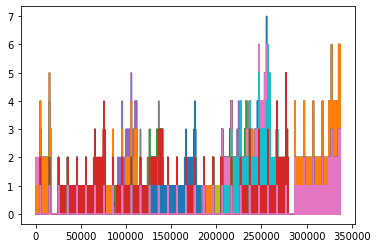

In [ ]:
plt.plot(v[0])

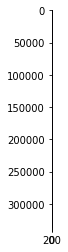

In [ ]:
plt.imshow(v[0])

In [ ]:
dfVMs.VM=encode(dfVMs,'VM',binary=True)

In [ ]:
df=dfVMs[dfVMs.step==60][["VM","Timestamp"]].groupby("Timestamp").sum()
df.sort_values(by='Timestamp',inplace=True)
df.VM=df.VM.map(bin)
df.index=df.index.map(lambda x:(x//60)*60)

In [ ]:
bin_to_list(bin(5))

['1', '0', '1']

In [ ]:
bin_to_list(df.VM.values[0])

['1', '0', '0', '0', '0', '0', '0']

In [ ]:
df.VM=df.VM.map(lambda x: bin_to_list(x))

In [ ]:
t0=int(min(df.index))
t1=int(max(df.index))
t=[k*60 for k in range((t1-t0)//60+1)]
(t1-t0)//60+1

330766

In [ ]:
n,m=len(weytop.VMs__Names()),(t1-t0)//60

In [ ]:
map=np.zeros((n+1,m+1))

In [ ]:
for ts in df.index:
  ch=str(df.loc[ts]["VM"])[::-1][:-2]
  col=(ts-t0)//60
  for i in range(len(ch)):
    if(ch[i]):
      try:
        map[i,col]=1
      except:
        print(i,ch[i],col,len(ch))
        break

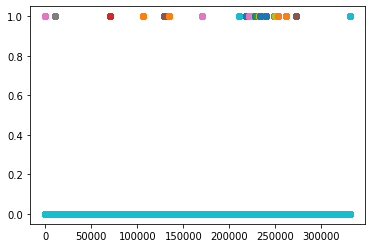

In [ ]:
for row in range(n+1):
  plt.scatter(list(range(m+1)),map[row,:])

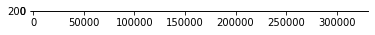

In [ ]:
plt.imshow(map)
plt.imsave("map.tiff",map)

In [ ]:
plt.hist2d(map)

TypeError: ignored

In [ ]:
img=np.float16(map)

In [ ]:
for ts in df.index:
  ch=str(df.loc[ts]["VM"])[::-1][:-2]
  if len(ch)>211 :
    print(ch)

In [ ]:
# Delete rows with NaN values
columns_to_not_consider=["Timestamp","step","Node","VM"]
columns_to_consider=[k for k in AllVMsDF.columns if k not in columns_to_not_consider ]
a=AllVMsDF[columns_to_consider]
a.dropna(how='all',inplace=True)
a_indexes=set(a.index)
dfsAll_indexes=set(AllVMsDF.index)
rows_to_drop=list(set.difference(dfsAll_indexes,a_indexes))
AllVMsDF.drop(index=rows_to_drop,inplace=True)
AllVMsDF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,Node,VM
1637154600s60vm100,1637154600,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,60,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,0,100
1637154660s60vm100,1637154660,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,60,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,0,100
1637154720s60vm100,1637154720,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,60,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,0,100
1637154780s60vm100,1637154780,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,60,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,0,100
1637154840s60vm100,1637154840,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,60,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637128800s10800vm346,1637128800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,1,346
1637139600s10800vm346,1637139600,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,1,346
1637150400s10800vm346,1637150400,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,1,346
1637107200s43200vm346,1637107200,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,43200,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,1,346


In [ ]:
AllNode

# Modelisation de la charge d'un noeud

In [ ]:
class NodeConsommationModel():
  #C_noeud = a somme_i C(VM_i) + b*n_vm + c
  # step = 60
  def __init__(self,resources,vms):
    self.resources=resources.copy()
    self.vms=vms.copy()
    self.models=dict()
    

  def fit(self):
    dfVMs_60 =self.vms[self.vms.step==60]
    dfVMs_60.dropna(inplace=True)
    #dfVMs_60.VM=encode(dfVMs_60,'VM',binary=True)
    dfVMs_60.Timestamp=dfVMs_60.Timestamp.map(synchro)
    dfVMs_60.Node=encode(dfVMs_60,'Node',binary=False)
    dfVMs_60_sum=dfVMs_60.groupby(by=["Timestamp","Node"]).sum()
    dfVMs_60_sum.VM = dfVMs_60_sum.VM.map(hammingDistance)
    self.vms=dfVMs_60_sum
    #dfVMs_60_sum.index=dfVMs_60_sum.index.map(lambda x:str(x[0])+'-'+str(x[1]))
    ###########
    dfResources_60=self.resources[self.resources.step==60]
    dfResources_60.Timestamp=dfResources_60.Timestamp.map(synchro)
    dfResources_60.Node=encode(dfResources_60,'Node',binary=False)
    dfResources_60=dfResources_60.groupby(["Timestamp","Node"]).first()
    #dfResources_60.index=dfResources_60.index.map(lambda x:str(x[0])+'-'+str(x[1]))
    inter = pd.merge(dfVMs_60_sum, dfResources_60, left_index=True, right_index=True)
    inter.VM = inter.step_x//60
    self.inter =inter
    
    #CPU
    # Attention loadavg n'est pas un pourcentage 
    # cpu_max est un pourcenatage pour les noeuds et pas pour les vms
    X_cpu=inter[["cpu_MAX_x","VM"]]
    #X_cpu["load"]=inter["maxcpu_MAX"_x]*inter["cpu_MAX"]
    y_cpu=inter["loadavg_MAX"]
    reg_cpu = linear_model.LinearRegression()
    reg_cpu.fit(X_cpu,y_cpu)
    self.models["cpu"]=reg_cpu,reg_cpu.score(X_cpu,y_cpu)
    #Network 
    ## netin
    X_netin=inter[["netin_MAX_x","VM"]]
    y_netin=inter["netin_MAX_y"]
    reg_netin = linear_model.LinearRegression()
    reg_netin.fit(X_netin,y_netin)
    self.models["netin"]=reg_netin,reg_netin.score(X_netin,y_netin)
    ## netout
    X_netout=inter[["netout_MAX_x","VM"]]
    y_netout=inter["netout_MAX_y"]
    reg_netout = linear_model.LinearRegression()
    reg_netout.fit(X_netout,y_netout)
    self.models["netout"]=reg_netout,reg_netout.score(X_netout,y_netout)

    # Mem
    ## RAM
    X_RAM=inter[["mem_MAX","VM"]]
    y_RAM=inter["memused_MAX"]
    reg_RAM = linear_model.LinearRegression()
    reg_RAM.fit(X_RAM,y_RAM)
    self.models["RAM"]=reg_netout,reg_netout.score(X_RAM,y_RAM)


    

    


In [ ]:
m0=NodeConsommationModel(dfResources,dfVMs)
reg=m0.fit()
m0.models

['vmfarm3.weytop.com', 'vpn1.airtop.io'] [0, 1]
['vmfarm3.weytop.com', 'vpn1.airtop.io'] [0, 1]


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- mem_MAX
Feature names seen at fit time, yet now missing:
- netout_

{'RAM': (LinearRegression(), -6.5697299777050615),
 'cpu': (LinearRegression(), 0.935705329122057),
 'netin': (LinearRegression(), 0.9505782370514909),
 'netout': (LinearRegression(), 0.7888001188592341)}

In [ ]:
cpu_model,_ =m0.models['netout']
print(cpu_model.coef_,cpu_model.intercept_)

[   0.99585645 -545.52709379] 6226.910209075365


In [ ]:
cpu_model.score

In [ ]:
dfVMs[dfVMs.cpu_MAX>1].describe()

,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM
count,1.810000e+02,181.000000,181.000000,1.810000e+02,1.810000e+02,1.810000e+02,181.0,1.810000e+02,1.810000e+02,1.810000e+02,1.810000e+02,181.000000,181.000000,181.000000,1.810000e+02,1.810000e+02,1.810000e+02,181.0,1.810000e+02,181.000000,1.810000e+02,1.810000e+02,181.000000
mean,1.630966e+09,2.160221,1.054280,4.472982e+09,3.826868e+09,1.302490e+11,0.0,4.680704e+06,4.854694e+05,3.610240e+07,3.561342e+07,337196.685083,2.090759,0.144410,4.400430e+09,3.712347e+09,1.302434e+11,0.0,3.797795e+04,1048.021270,4.306310e+05,3.799615e+06,227.801105
std,6.634952e+06,0.831176,0.063100,1.195367e+09,1.100498e+09,1.152653e+11,0.0,4.686987e+06,1.593665e+06,2.236260e+07,2.144922e+07,288600.065816,0.530272,0.185535,1.040654e+09,6.352318e+08,1.152701e+11,0.0,1.327836e+05,1899.654671,1.489592e+06,1.357763e+07,110.121116
min,1.607558e+09,2.000000,1.000014,2.147484e+09,2.005197e+09,3.435974e+10,0.0,2.988333e+01,8.950000e+00,2.403413e+04,1.004416e+05,1800.000000,1.789954,0.006802,2.147484e+09,1.953563e+09,3.333738e+10,0.0,1.316718e+01,0.247546,1.011674e+02,2.330702e+03,100.000000
25%,1.628726e+09,2.000000,1.026034,4.294967e+09,3.601673e+09,3.435974e+10,0.0,1.383041e+06,1.787919e+04,1.968956e+07,2.346202e+07,43200.000000,2.000000,0.032956,4.294967e+09,3.588526e+09,3.435974e+10,0.0,2.847597e+03,444.252167,6.579032e+04,1.046505e+05,108.000000
50%,1.634170e+09,2.000000,1.035594,4.294967e+09,3.645845e+09,3.435974e+10,0.0,3.400174e+06,4.972074e+04,3.363926e+07,2.913559e+07,604800.000000,2.000000,0.053934,4.294967e+09,3.612096e+09,3.435974e+10,0.0,6.685179e+03,640.320074,1.112764e+05,1.715514e+05,300.000000
75%,1.636448e+09,2.000000,1.052495,4.294967e+09,3.793257e+09,2.684355e+11,0.0,6.621261e+06,1.490844e+05,4.627939e+07,4.608578e+07,604800.000000,2.000000,0.164114,4.294967e+09,3.778149e+09,2.684355e+11,0.0,2.230924e+04,958.391846,2.768691e+05,4.331211e+05,334.000000
max,1.637107e+09,8.000000,1.443590,1.717987e+10,1.623771e+10,2.684355e+11,0.0,2.852102e+07,1.635004e+07,9.112033e+07,9.209138e+07,604800.000000,8.000000,0.950223,1.717987e+10,1.125725e+10,2.684355e+11,0.0,1.336702e+06,16263.560031,1.549147e+07,7.134581e+07,345.000000


In [ ]:
m0.inter

,,maxcpu_MAX_x,cpu_MAX_x,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX_x,netout_MAX_x,diskread_MAX,diskwrite_MAX,step_x,maxcpu_AVERAGE_x,cpu_AVERAGE_x,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE_x,netout_AVERAGE_x,diskread_AVERAGE,diskwrite_AVERAGE,VM,loadavg_MAX,maxcpu_MAX_y,cpu_MAX_y,iowait_MAX,memtotal_MAX,memused_MAX,swaptotal_MAX,swapused_MAX,roottotal_MAX,rootused_MAX,netin_MAX_y,netout_MAX_y,step_y,loadavg_AVERAGE,maxcpu_AVERAGE_y,cpu_AVERAGE_y,iowait_AVERAGE,memtotal_AVERAGE,memused_AVERAGE,swaptotal_AVERAGE,swapused_AVERAGE,roottotal_AVERAGE,rootused_AVERAGE,netin_AVERAGE_y,netout_AVERAGE_y,Resfname
Timestamp,Node,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1637154720,1,26.0,1.649014,4.294967e+10,3.545565e+10,3.435974e+11,0.0,116.193333,29.621667,0.000000e+00,1.737984e+04,600,26.0,1.649014,4.294967e+10,3.545565e+10,3.435974e+11,0.0,116.193333,29.621667,0.000000e+00,1.737984e+04,10,3.771167,40.0,0.091340,0.000008,6.744238e+10,5.178850e+10,1.023406e+09,629309440.0,1.965883e+12,8.305297e+11,4560.686667,4.850000,60,3.771167,40.0,0.091340,0.000008,6.744238e+10,5.178850e+10,1.023406e+09,629309440.0,1.965883e+12,8.305297e+11,4560.686667,4.850000,vpn1
1637154780,1,26.0,1.650719,4.294967e+10,3.545542e+10,3.435974e+11,0.0,141.881667,60.563333,0.000000e+00,3.037269e+04,600,26.0,1.650719,4.294967e+10,3.545542e+10,3.435974e+11,0.0,141.881667,60.563333,0.000000e+00,3.037269e+04,10,3.516000,40.0,0.091296,0.000006,6.744238e+10,5.178660e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5071.528333,52.981667,60,3.516000,40.0,0.091296,0.000006,6.744238e+10,5.178660e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5071.528333,52.981667,vpn1
1637154840,1,26.0,1.662701,4.294967e+10,3.545551e+10,3.435974e+11,0.0,286.665000,61.921667,0.000000e+00,2.047829e+04,600,26.0,1.662701,4.294967e+10,3.545551e+10,3.435974e+11,0.0,286.665000,61.921667,0.000000e+00,2.047829e+04,10,3.629167,40.0,0.099240,0.000009,6.744238e+10,5.178489e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4774.568333,33.398333,60,3.629167,40.0,0.099240,0.000009,6.744238e+10,5.178489e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,4774.568333,33.398333,vpn1
1637154900,1,26.0,1.650681,4.294967e+10,3.545541e+10,3.435974e+11,0.0,32.116667,17.616667,0.000000e+00,1.726293e+04,600,26.0,1.650681,4.294967e+10,3.545541e+10,3.435974e+11,0.0,32.116667,17.616667,0.000000e+00,1.726293e+04,10,4.108667,40.0,0.111171,0.000012,6.744238e+10,5.178410e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5283.806667,12.400000,60,4.108667,40.0,0.111171,0.000012,6.744238e+10,5.178410e+10,1.023406e+09,629309440.0,1.965883e+12,8.305298e+11,5283.806667,12.400000,vpn1
1637154960,0,24.0,2.978907,5.153961e+10,4.290315e+10,4.123169e+11,0.0,79563.421667,5059.416667,4.581120e+05,1.410018e+08,720,24.0,2.978907,5.153961e+10,4.290315e+10,4.123169e+11,0.0,79563.421667,5059.416667,4.581120e+05,1.410018e+08,12,5.830333,32.0,0.185966,0.000005,2.700643e+11,6.912730e+10,4.999606e+09,38797312.0,7.804286e+11,7.361477e+11,79343.661667,5170.018333,60,5.830333,32.0,0.185966,0.000005,2.700643e+11,6.912730e+10,4.999606e+09,38797312.0,7.804286e+11,7.361477e+11,79343.661667,5170.018333,airtop-vm-farm3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637158860,1,2.0,0.513050,4.294967e+09,3.557217e+09,3.435974e+10,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,60,2.0,0.513050,4.294967e+09,3.557217e+09,3.435974e+10,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,1,4.533667,40.0,0.115097,0.000206,6.744238e+10,5.180503e+10,1.023406e+09,629309440.0,1.965883e+12,8.305309e+11,16596.620000,3050.140000,60,4.533667,40.0,0.115097,0.000206,6.744238e+10,5.180503e+10,1.023406e+09,629309440.0,1.965883e+12,8.305309e+11,16596.620000,3050.140000,vpn1
1637158920,0,24.0,3.040602,5.153961e+10,4.290017e+10,4.123169e+11,0.0,211090.333333,5652

In [ ]:
a=dfVMs[dfVMs.Timestamp==1637154720]
a

,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM,Node
1637154720s60VM307,1637154720,2.0,0.513854,4.294967e+09,3.576129e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,60,2.0,0.513854,4.294967e+09,3.576129e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,307,vpn1.airtop.io
1637154720s60VM304,1637154720,2.0,0.015335,4.294967e+09,3.469833e+09,3.435974e+10,0.0,17.963333,11.678333,0.0,9665.706667,60,2.0,0.015335,4.294967e+09,3.469833e+09,3.435974e+10,0.0,17.963333,11.678333,0.0,9665.706667,304,vpn1.airtop.io
1637154720s60VM101,1637154720,2.0,0.513385,4.294967e+09,3.557201e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,60,2.0,0.513385,4.294967e+09,3.557201e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,101,vpn1.airtop.io
1637154720s60VM100,1637154720,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,60,4.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,100,vpn1.airtop.io
1637154720s60VM248,1637154720,4.0,0.009563,4.294967e+09,3.610451e+09,3.435974e+10,0.0,17.298333,0.000000,0.0,341.333333,60,4.0,0.009563,4.294967e+09,3.610451e+09,3.435974e+10,0.0,17.298333,0.000000,0.0,341.333333,248,vpn1.airtop.io
1637154720s60VM321,1637154720,2.0,0.023196,4.294967e+09,3.627957e+09,3.435974e+10,0.0,17.298333,0.000000,0.0,1988.266667,60,2.0,0.023196,4.294967e+09,3.627957e+09,3.435974e+10,0.0,17.298333,0.000000,0.0,1988.266667,321,vpn1.airtop.io
1637154720s60VM320,1637154720,2.0,0.512786,4.294967e+09,3.660014e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,60,2.0,0.512786,4.294967e+09,3.660014e+09,3.435974e+10,0.0,0.000000,0.000000,0.0,0.000000,320,vpn1.airtop.io
1637154720s60VM256,1637154720,4.0,0.009192,4.294967e+09,3.463093e+09,3.435974e+10,0.0,7.093333,10.205000,0.0,68.266667,60,4.0,0.009192,4.294967e+09,3.463093e+09,3.435974e+10,0.0,7.093333,10.205000,0.0,68.266667,256,vpn1.airtop.io
1637154720s60VM286,1637154720,4.0,0.026521,4.294967e+09,3.327882e+09,3.435974e+10,0.0,17.298333,0.000000,0.0,0.000000,60,4.0,0.026521,4.294967e+09,3.327882e+09,3.435974e+10,0.0,17.298333,0.000000,0.0,0.000000,286,vpn1.airtop.io
1637154720s60VM322,1637154720,2.0,0.010613,4.294967e+09,3.581119e+09,3.435974e+10,0.0,17.298333,0.000000,0.0,1228.800000,60,2.0,0.010613,4.294967e+09,3.581119e+09,3.435974e+10,0.0,17.298333,0.000000,0.0,1228.800000,322,vpn1.airtop.io


In [ ]:
inter

In [ ]:
cpu_model.intercept_

2.068739637972926

# Modelisation de la consommation d'une machine virtuelle

In [ ]:
class VMConsommationModel():
  def k():
    return 3
  def step():
    # 3hours 
    return 10800
  def __init__(self,vms):
    step=VMConsommationModel.step()
    self.vms=vms.copy()
    self.vms=self.vms[self.vms.step==step].dropna()
    self.vms_idx=self.vms.VM.unique()
    self.vms["hour"]=self.vms.Timestamp.map(hour)
    self.vms["day"]=self.vms.Timestamp.map(day)
    self.vms["weekday"]=self.vms.Timestamp.map(weekday)
    self.vms["isweekend"]=self.vms.Timestamp.map(isweekend)
    self.vms["date"]=self.vms.Timestamp.map(fromtimestamp)
  def generate_clusters(self,random_state=42):
    k=VMConsommationModel.k()
    lvms = self.vms.VM.unique()
    cols=['cpu_MAX','mem_MAX','netin_MAX','netout_MAX','diskread_MAX','diskwrite_MAX']
    vms_kmeans=dict()
    err=[]
    for vm_i in lvms:
      X=self.vms[self.vms.VM==vm_i][cols]
      try:
        Kmeans=KMeans(n_clusters=k,random_state=random_state)
        Kmeans.fit(X.to_numpy())
        vms_kmeans[vm_i]=Kmeans
      except:
        err.append(vm_i)
    self.vms_Kmeans=vms_kmeans
    self.vms_err=err
    self.vms["K"]=0
    def update_cluster(x):
      vm= x.at['VM']
      X=x[cols]
      if (vm in vms_kmeans):
        k = vms_kmeans[vm].predict(X.to_numpy().reshape(1, -1))[0]
        return k
      else:
        return 0
    self.vms["K"]=self.vms.apply(update_cluster,axis=1)
    return vms_kmeans,err,self.vms["K"]
  def fit(self,random_state=42):
    vms_clfs=dict()
    lvms = self.vms.VM.unique()
    cols=["hour","day","weekday","isweekend"]
    for vm_i in lvms:
      clf = RandomForestClassifier(random_state=random_state)
      X=self.vms[self.vms.VM==vm_i][cols]
      y=self.vms[self.vms.VM==vm_i]['K']
      clf.fit(X,y)
      score=clf.score(X,y)
      vms_clfs[vm_i]=(clf,score)
    self.vms_clfs=vms_clfs
    return self.vms_clfs



    
  

In [ ]:
m1=VMConsommationModel(dfVMs)

In [ ]:
kmeans_s,err,K=m1.generate_clusters()

In [ ]:
kmeans_s

{101: KMeans(n_clusters=3, random_state=42),
 102: KMeans(n_clusters=3, random_state=42),
 104: KMeans(n_clusters=3, random_state=42),
 107: KMeans(n_clusters=3, random_state=42),
 108: KMeans(n_clusters=3, random_state=42),
 111: KMeans(n_clusters=3, random_state=42),
 112: KMeans(n_clusters=3, random_state=42),
 157: KMeans(n_clusters=3, random_state=42),
 158: KMeans(n_clusters=3, random_state=42),
 160: KMeans(n_clusters=3, random_state=42),
 182: KMeans(n_clusters=3, random_state=42),
 194: KMeans(n_clusters=3, random_state=42),
 196: KMeans(n_clusters=3, random_state=42),
 204: KMeans(n_clusters=3, random_state=42),
 205: KMeans(n_clusters=3, random_state=42),
 206: KMeans(n_clusters=3, random_state=42),
 209: KMeans(n_clusters=3, random_state=42),
 210: KMeans(n_clusters=3, random_state=42),
 211: KMeans(n_clusters=3, random_state=42),
 215: KMeans(n_clusters=3, random_state=42),
 217: KMeans(n_clusters=3, random_state=42),
 218: KMeans(n_clusters=3, random_state=42),
 220: KMea

In [ ]:
kmeans_338 =kmeans_s[338]
kmeans_338.

KMeans(n_clusters=3, random_state=42)

In [ ]:
clfs=m1.fit()

In [ ]:
err

[208, 228, 231, 242, 159, 229, 316, 254, 235]

In [ ]:
clfs

{101: (RandomForestClassifier(random_state=42), 0.9714285714285714),
 102: (RandomForestClassifier(random_state=42), 0.9285714285714286),
 104: (RandomForestClassifier(random_state=42), 0.9785714285714285),
 107: (RandomForestClassifier(random_state=42), 0.927536231884058),
 108: (RandomForestClassifier(random_state=42), 0.8695652173913043),
 111: (RandomForestClassifier(random_state=42), 1.0),
 112: (RandomForestClassifier(random_state=42), 0.9130434782608695),
 157: (RandomForestClassifier(random_state=42), 0.8461538461538461),
 158: (RandomForestClassifier(random_state=42), 0.8043478260869565),
 159: (RandomForestClassifier(random_state=42), 1.0),
 160: (RandomForestClassifier(random_state=42), 0.6666666666666666),
 182: (RandomForestClassifier(random_state=42), 0.6923076923076923),
 194: (RandomForestClassifier(random_state=42), 0.8571428571428571),
 196: (RandomForestClassifier(random_state=42), 0.8928571428571429),
 204: (RandomForestClassifier(random_state=42), 0.9),
 205: (Rand

In [ ]:
X=list(clfs.keys())
Y=[v[1] for v in clfs.values()]

In [ ]:
Y

[0.7647058823529411,
 0.8461538461538461,
 0.9642857142857143,
 0.6666666666666666,
 0.7142857142857143,
 0.9272727272727272,
 0.5571428571428572,
 0.813953488372093,
 0.9090909090909091,
 0.6428571428571429,
 0.8333333333333334,
 1.0,
 0.6285714285714286,
 0.9714285714285714,
 1.0,
 0.8787878787878788,
 1.0,
 0.6363636363636364,
 0.6923076923076923,
 0.6442307692307693,
 0.625,
 0.8387096774193549,
 0.9069767441860465,
 0.9534883720930233,
 0.8181818181818182,
 0.7142857142857143,
 0.5384615384615384,
 0.9714285714285714,
 0.8181818181818182,
 0.6666666666666666,
 0.6666666666666666,
 0.9785714285714285,
 0.9767441860465116,
 1.0,
 1.0,
 0.8571428571428571,
 0.8857142857142857,
 0.8461538461538461,
 0.5714285714285714,
 0.9428571428571428,
 0.9285714285714286,
 0.75,
 1.0,
 0.75,
 0.9069767441860465,
 0.6666666666666666,
 0.5,
 1.0,
 1.0,
 0.9047619047619048,
 1.0,
 0.6666666666666666,
 0.8928571428571429,
 0.7777777777777778,
 0.5555555555555556,
 0.9571428571428572,
 0.75,
 1.0,
 0.

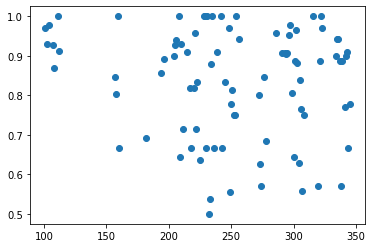

In [ ]:
plt.scatter(X,Y)


In [ ]:
m1.vms[m1.vms.K==3]

,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM,Node,hour,day,weekday,isweekend,date,K
1632333600s10800VM306,1632333600,2.0,0.524796,4.294967e+09,3.608798e+09,3.435974e+10,0.0,1.439950e+03,582.366667,5.635681e+06,9.309833e+05,10800,2.0,0.022019,4.294967e+09,3.607875e+09,3.435974e+10,0.0,109.266481,25.571204,53002.050370,16364.420741,306,vpn1.airtop.io,9,22,2,0,2021-09-22 18:00:00,3
1632366000s10800VM306,1632366000,2.0,0.355620,4.294967e+09,3.609177e+09,3.435974e+10,0.0,1.018779e+05,4890.440000,3.075318e+06,4.721999e+06,10800,2.0,0.022319,4.294967e+09,3.607952e+09,3.435974e+10,0.0,817.007593,61.609722,19710.293333,47585.754074,306,vpn1.airtop.io,9,23,3,0,2021-09-23 03:00:00,3
1624600800s10800VM157,1624600800,8.0,0.122517,1.717987e+10,3.158460e+09,3.435974e+10,0.0,1.552514e+05,6386.920000,6.590976e+05,5.245713e+06,10800,8.0,0.013490,1.717987e+10,3.044685e+09,3.435974e+10,0.0,3049.523528,47.952037,3694.980741,37528.983704,157,vpn1.airtop.io,6,25,4,0,2021-06-25 06:00:00,3
1624622400s10800VM157,1624622400,8.0,0.073990,1.717987e+10,3.291085e+09,3.435974e+10,0.0,1.277242e+04,1802.443333,3.686281e+05,4.518221e+06,10800,8.0,0.013164,1.717987e+10,3.122990e+09,3.435974e+10,0.0,2011.626685,21.542944,2140.017778,34900.138667,157,vpn1.airtop.io,6,25,4,0,2021-06-25 12:00:00,3
1624633200s10800VM157,1624633200,8.0,0.134914,1.717987e+10,3.149479e+09,3.435974e+10,0.0,1.076411e+05,955.983333,1.482854e+05,1.623770e+07,10800,8.0,0.014486,1.717987e+10,3.063085e+09,3.435974e+10,0.0,3065.627870,22.416667,1682.868148,192311.314960,157,vpn1.airtop.io,6,25,4,0,2021-06-25 15:00:00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636632000s10800VM337,1636632000,2.0,0.114863,4.294967e+09,3.597096e+09,3.435974e+10,0.0,1.342629e+04,8.950000,6.144896e+06,7.717359e+05,10800,2.0,0.013192,4.294967e+09,3.595460e+09,3.435974e+10,0.0,2779.828611,0.436944,49741.700741,23873.810963,337,vmfarm3.weytop.com,11,11,3,0,2021-11-11 12:00:00,3
1636588800s10800VM339,1636588800,2.0,0.660830,4.294967e+09,3.536200e+09,3.435974e+10,0.0,4.871086e+04,7238.723333,2.983686e+07,7.647311e+06,10800,2.0,0.039316,4.294967e+09,3.519815e+09,3.435974e+10,0.0,3770.794500,756.034944,539336.343700,201432.490670,339,vmfarm3.weytop.com,11,11,3,0,2021-11-11 00:00:00,3
1636686000s10800VM339,1636686000,2.0,0.551692,4.294967e+09,3.523743e+09,3.435974e+10,0.0,1.223891e+04,6916.873333,1.919294e+07,1.516283e+06,10800,2.0,0.019532,4.294967e+09,3.522796e+09,3.435974e+10,0.0,2527.216426,737.246648,183831.751110,55211.425185,339,vmfarm3.weytop.com,11,12,4,0,2021-11-12 03:00:00,3
1636448400s10800VM334,1636448400,2.0,0.638854,4.294967e+09,3.570655e+09,3.435974e+10,0.0,2.775237e+06,29174.680000,1.383613e+07,6.863599e+06,10800,2.0,0.016155,4.294967e+09,3.569398e+09,3.435974e+10,0.0,19520.309741,899.427556,119769.505190,65499.207111,334,vmfarm3.weytop.com,11,9,1,0,2021-11-09 09:00:00,3


In [ ]:
dfVMs_3h=dfVMs[dfVMs.step==10800]
dfVMs_3h[dfVMs_3h.VM==315]

,Timestamp,maxcpu_MAX,cpu_MAX,maxmem_MAX,mem_MAX,maxdisk_MAX,disk_MAX,netin_MAX,netout_MAX,diskread_MAX,diskwrite_MAX,step,maxcpu_AVERAGE,cpu_AVERAGE,maxmem_AVERAGE,mem_AVERAGE,maxdisk_AVERAGE,disk_AVERAGE,netin_AVERAGE,netout_AVERAGE,diskread_AVERAGE,diskwrite_AVERAGE,VM,Node
1636405200s10800VM315,1636405200,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
1636416000s10800VM315,1636416000,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
1636426800s10800VM315,1636426800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
1636437600s10800VM315,1636437600,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
1636448400s10800VM315,1636448400,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637107200s10800VM315,1637107200,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
1637118000s10800VM315,1637118000,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
1637128800s10800VM315,1637128800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com
1637139600s10800VM315,1637139600,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,10800,2.0,NaN,4.294967e+09,NaN,3.435974e+10,0.0,NaN,NaN,NaN,NaN,315,vmfarm3.weytop.com


In [ ]:
dfResources.step.unique()

array([    60,   1800,  10800,  43200, 604800])